In [1]:
import pandas as pd
import matplotlib
import warnings
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import analysis_utils
from copy import deepcopy

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'inference', 'fireprot_mapped_preds_clusters.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

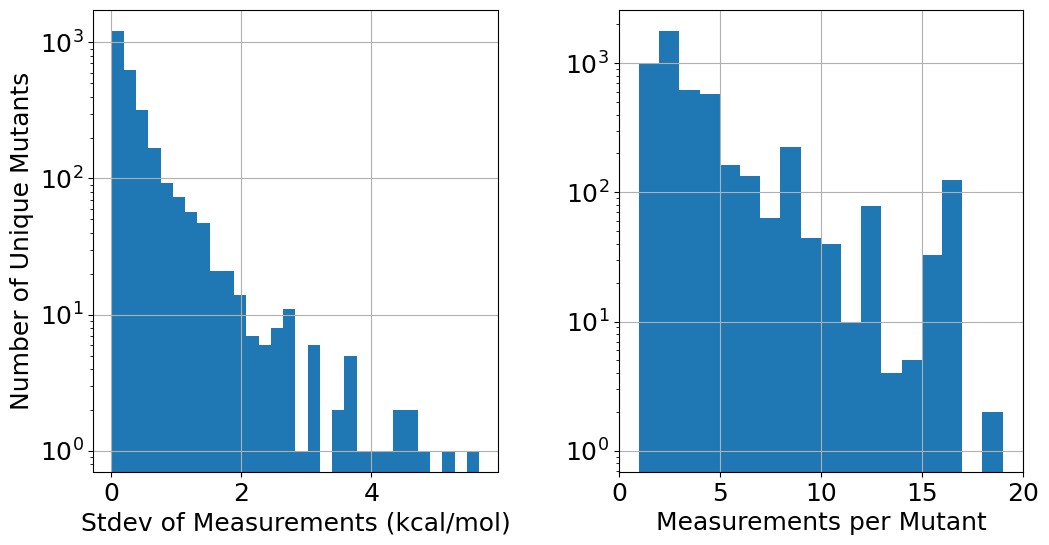

In [2]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
meas = pd.read_csv(os.path.join(path, 'data', 'preprocessed', 'fireprot_mapped.csv'), index_col=0)
d = meas['ddG'].reset_index().groupby('uid').std().dropna()
d.loc[d['ddG']>0].hist(bins=30, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Stdev of Measurements (kcal/mol)')
axes[0].set_ylabel('Number of Unique Mutants')
axes[0].set_title('')

d = meas['ddG'].reset_index().groupby('uid').count().dropna()
d.loc[d['ddG']>0].hist(bins=882, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('Measurements per Mutant')
#axes[1].set_ylabel('Number of Unique Mutants')
axes[1].set_xlim(0,20)
axes[1].set_title('')
fig.savefig(os.path.join(path, 'data', 'extended', 'figure_data', 'supp_fig1.svg'), bbox_inches='tight')

Text(0.5, 1.0, '')

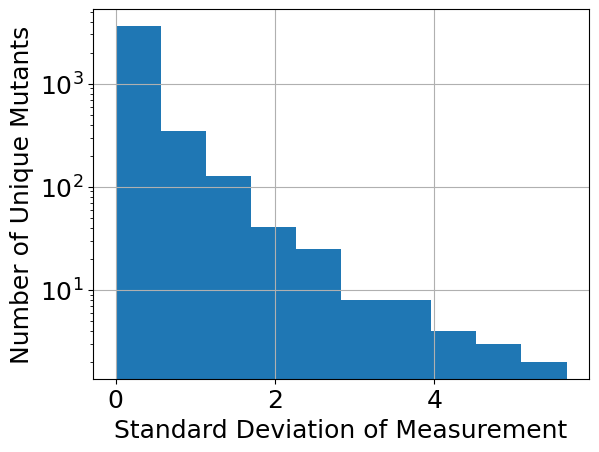

In [3]:
meas = pd.read_csv(os.path.join(path, 'data', 'preprocessed', 'fireprot_mapped.csv'), index_col=0)
meas['ddG'].reset_index().groupby('uid').std().dropna().hist()
plt.yscale('log')
plt.xlabel('Standard Deviation of Measurement')
plt.ylabel('Number of Unique Mutants')
plt.title('')

In [4]:
### load and preprocess data
preds_loc = os.path.join(path, 'data', 'analysis', 'fireprot_analysis.csv')

# load main data
db = pd.read_csv(preds_loc, index_col=0)
db['uid2'] = db['code'] + '_' + db['position'].fillna(-1000000).astype(int).astype(str) + db['mutation']
db = db.reset_index().set_index(['uid', 'uid2'])

# drop locations with no indicated position
#db = db.dropna(subset=['position'])

# uid (specified in preprocessing) is the index for this database
db = db.reset_index()

# extract information about data origins
db['ProTherm'] = db['datasets'].apply(lambda x: 'ProTherm' in str(x))
db['FireProt'] = db['datasets'].apply(lambda x: 'FireProt' in str(x))
db['ThermoFluor'] = db['method'].apply(lambda x: 'ThermoFluor' in str(x))

# get only curated mutations for all future analyses
#db = db.loc[db['is_curated']]

# extract ground-truth labels and selected attributes of the data
db_measurements = db.groupby(['uid']).agg({'ddG':'median', 'dTm':'median', 'ProTherm':'max', 'FireProt':'max', 'ThermoFluor':'max', 'code':'first', 'is_curated':'median', 'window_start': 'first'})
print('Number of unique mutations with computed predictions', len(db_measurements))

db_ddg = db_measurements[['ddG']]
db_clusters = db.groupby('uid').first()[['cluster']]
db_training = db.groupby('uid').first()[[c for c in db.columns if 'overlaps' in c]]

db = db.set_index(['uid', 'uid2'])
# use ddG of unfolding so that both dTm and ddG are positive for stabilizing
db_measurements['ddG'] = -db_measurements['ddG']

# extract prediction columns
incl = [col for col in db.columns if '_dir' in col and not 'runtime' in col]
# get only unique mutations (predictions are always the same)
db_preds = db[incl].drop_duplicates()

# extract runtimes for each prediction type
db_runtimes = db[[col for col in db.columns if 'runtime' in col] + ['code']].drop_duplicates()
# estimate the per-mutation runtime (the code takes about 6 seconds to run 6330 mutations)
db_runtimes['runtime_korpm_dir'] = 0.001

# reassign the Tranception runtimes to be per-mutation (by dividing by the number of mutations)
for col in [c for c in db_runtimes.columns if 'tranception' in c]:
    grouped = db_runtimes.groupby('code')[col]
    mean_values = grouped.mean()
    group_sizes = grouped.size()

    # Divide mean values by group sizes
    divided_values = mean_values / group_sizes
    # Merge the divided_values back to the original DataFrame
    db_runtimes = db_runtimes.merge(divided_values.rename('divided_value'), left_on='code', right_index=True)
    # Reassign the 'target_column' values with the divided values
    db_runtimes[col] = db_runtimes['divided_value']
    # Drop the 'divided_value' column
    db_runtimes = db_runtimes.drop('divided_value', axis=1)

# load effective number of sequences from separate file (generated by MSA transformer)
neff = pd.read_csv(os.path.join(path, 'data', 'features', 'neff_fireprot.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff', 'sequence_length']
neff = neff.groupby(level=0).max()
neff = neff[['neff']]

# drop any NaN columns
db_preds = db_preds.dropna(how='all', axis=1)

# output a glimpse of the dataframe
db_preds

Number of unique mutations with computed predictions 6455


mpnn_10_00_dir  mpnn_20_00_dir  mpnn_30_00_dir   mif_dir  \
uid       uid2                                                                  
1A23_170A 1A23_151A       -4.949540       -5.244984       -5.672250 -5.430375   
1A23_49S  1A23_30S         2.077144        2.085694       -1.302507  1.864485   
1A23_51L  1A23_32L         0.228933        2.368069       -0.227686  1.119251   
          1A23_32L         0.228933        2.368069       -0.227686  1.119251   
          1A23_32L         0.228933        2.368069       -0.227686  1.119251   
...                             ...             ...             ...       ...   
6TQ3_97A  6TQ3_91A         1.426476        1.061871       -0.051376  1.937819   
6TQ3_97K  6TQ3_91K        -1.633844       -1.412267       -0.688994 -3.846951   
6TQ3_9P   6TQ3_3P          1.479089        0.600413        1.845578  1.529709   
8TIM_179A 8TIM_178A       -0.048543        0.312612       -0.108129  1.211097   
8TIM_193A 8TIM_192A        0.275487        2.610600        1.680574 -0.412504   

                     mifst_dir  esmif_monomer_dir  pll_esmif_monomer_dir  \
uid       uid2                                                             
1A23_170A 1A23_151A  -9.428463          -0.058681               6.139080   
1A23_49S  1A23_30S   -6.805952          -0.043713               6.139080   
1A23_51L  1A23_32L   -7.800102          -0.042389               6.139080   
          1A23_32L   -7.800102          -0.042389               6.139080   
          1A23_32L   -7.800102          -0.042389               6.139080   
...                        ...                ...                    ...   
6TQ3_97A  6TQ3_91A   -0.323130           0.005651               2.714652   
6TQ3_97K  6TQ3_91K   -6.354403          -0.015521               2.714652   
6TQ3_9P   6TQ3_3P     1.332036          -0.012842               2.714652   
8TIM_179A 8TIM_178A   1.235412           0.004287               2.813355   
8TIM_193A 8TIM_192A  -3.617151          -0.005032               2.813355   

                     esm2_3B_dir  esm2_15B_half_dir  esmif_multimer_dir  ...  \
uid       uid2                                                           ...   
1A23_170A 1A23_151A   -11.686458         -11.403809           -0.058681  ...   
1A23_49S  1A23_30S    -11.571676         -11.668701           -0.043712  ...   
1A23_51L  1A23_32L    -13.755667         -13.076172           -0.042389  ...   
          1A23_32L    -13.755667         -13.076172           -0.042389  ...   
          1A23_32L    -13.755667         -13.076172           -0.042389  ...   
...                          ...                ...                 ...  ...   
6TQ3_97A  6TQ3_91A      2.301441           2.237305            0.004414  ...   
6TQ3_97K  6TQ3_91K     -4.896001          -5.344726           -0.009634  ...   
6TQ3_9P   6TQ3_3P      -1.533729          -2.478516           -0.012137  ...   
8TIM_179A 8TIM_178A     0.568380          -0.851563            0.004968  ...   
8TIM_193A 8TIM_192A    -0.143130          -1.933594           -0.004131  ...   

                     to_alanine_dir  from_proline_dir  from_glycine_dir  \
uid       uid2                                                            
1A23_170A 1A23_151A             1.0               0.0               0.0   
1A23_49S  1A23_30S              0.0               0.0               0.0   
1A23_51L  1A23_32L              0.0               0.0               0.0   
          1A23_32L              0.0               0.0               0.0   
          1A23_32L              0.0               0.0               0.0   
...                             ...               ...               ...   
6TQ3_97A  6TQ3_91A              1.0               0.0               0.0   
6TQ3_97K  6TQ3_91K              0.0               0.0               0.0   
6TQ3_9P   6TQ3_3P               0.0               1.0               0.0   
8TIM_179A 8TIM_178A             1.0               0.0               0.0   
8TIM_193A 8TIM_192A             1.0  

Original unique mutations: 13848
Detected 631 interface mutations
Dropped 631 interface mutations
Unique mutations in chosen set: 13060
Unique clusters (protein families with significant structural homology): 87


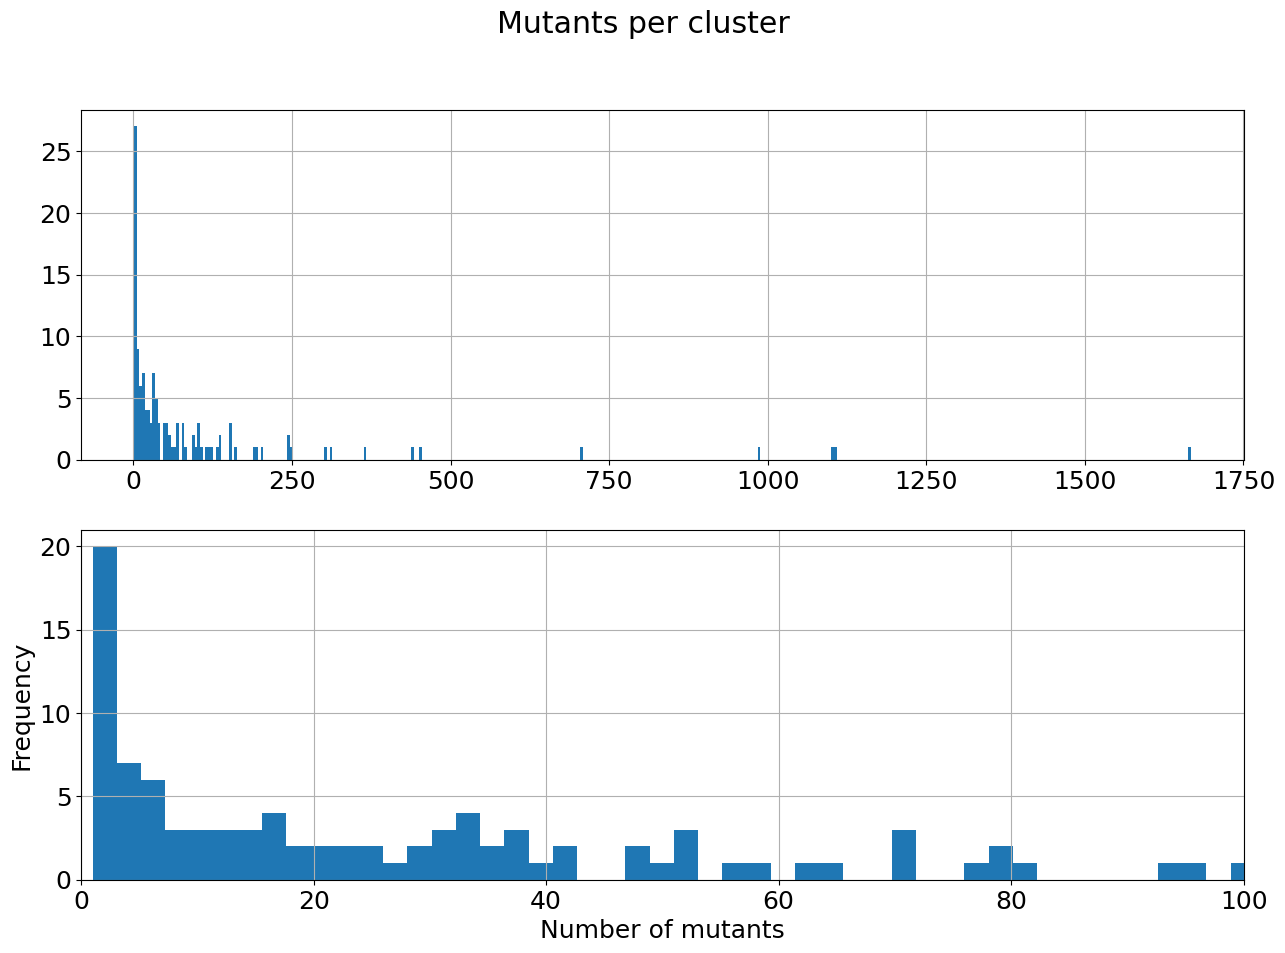

In [5]:
# compile predictions and measurements for statistical analysis
db_class = db_preds.join(db_measurements).drop('code', axis=1).join(db_clusters).reset_index('uid2', drop=True) #.join(db_runtimes.drop('code', axis=1))
print('Original unique mutations:', len(db_class))

# number of interface mutations (7 Angstrom cross-chain cutoff)
print(f'Detected {len(db_class.loc[db_class["on_interface_dir"].astype(bool)])} interface mutations')

l1 = len(db_class)
db_class = db_class.loc[~db_class['on_interface_dir'].astype(bool)]
l2 = len(db_class)
print(f'Dropped {l1-l2} interface mutations')

# can uncomment to look at non-ProTherm or Curated mutaions
#db_class = db_class.loc[~db_class['ProTherm'].astype(bool)]
#db_class = db_class.loc[~(db_class.index.str[:4]=='1PGA')]
#db_class = db_class.loc[db_class['is_curated'].astype(bool)]

# define categories
evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh', 'saprot']
structural = ['mpnn', 'mif', 'mifst', 'esmif', 'mutcomputex']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro', 'q3421']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM', 'korpm']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo', 'Cartddg']
transfer = ['stability-oracle']

# determine which columns contain predictions
original_pred_cols = db_class.columns[db_class.columns.str.contains('|'.join(evolutionary + structural + supervised + untrained + potential + biophysical + transfer))]
#original_pred_cols = list(original_pred_cols.drop(['reduced_msa_file', 'full_msa_file', 'tranception_dms', 'msa_weights']))
original_pred_cols = [c for c in original_pred_cols if not 'runtime' in c]
original_pred_cols = [c for c in original_pred_cols if not 'cluster' in c]
original_pred_cols = [c for c in original_pred_cols if not 'overlaps' in c]
original_pred_cols = [c for c in original_pred_cols if not 'pll' in c]
#print(original_pred_cols)

# separate runtimes into another dataframe
db_runtimes = db[[c for c in db.columns if 'runtime' in c]]

# remove individual predictions from models designed to be ensembled
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

db_class['ddG_dir'] = db_class['ddG']
db_class['dTm_dir'] = db_class['dTm']

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif']
supervised = ['cartesian_ddg', 'korpm']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols] /= db_class_rescaled[original_pred_cols].std()

db_class['structural_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in structural])]].mean(axis=1)
db_class['evolutionary_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in evolutionary])]].mean(axis=1)
db_class['supervised_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in supervised])]].mean(axis=1)
db_class['clustered_ensemble_dir'] = db_class[['supervised_dir', 'structural_dir', 'evolutionary_dir']].mean(axis=1)

db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']

# reduce the working dataframe to only the columns of interest
db_class = db_class[original_pred_cols + ['ddG', 'dTm', 'cluster']]

# define extra columns (ensemble and baselines)
db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
db_class['random_dir'] = np.random.normal(loc=db['ddG'].mean(), size=len(db_class))
#db_class['korpm_dir'] = db_class['KORPMD_dir']
db_class['ddG_dir'] = db_class['ddG']
db_class['upper_bound_dir'] = db_class['ddG'] + np.random.normal(loc=0, size=len(db_class))

#db_class = db_class.reset_index('uid2', drop=True)

fig, axes = plt.subplots(2, figsize=(15, 10)) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=400, ax=axes[0])
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,100])
plt.suptitle('Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

group_counts = db_class.groupby('cluster').count().iloc[:, 0]
large_groups = group_counts > 10
filtered_df = db_class[db_class['cluster'].isin(large_groups[large_groups].index)]
db_class = filtered_df

#db_class = db_class.loc[~db_feats_2['on_interface']]
#print(f'Dropped {l2-len(db_class)} mutations in binding regions')

db_class

print('Unique mutations in chosen set:', len(db_class))
print('Unique clusters (protein families with significant structural homology):', len(db_class['cluster'].unique()))

In [6]:
# TABLE 1
# Note: due to changes in the dependencies and small changes to preprocessing,
# results have changed very slightly from the current revision, but do not affect
# the interpretation of results or conclusions

# could replace stats=() with ('n', 'MCC', 'auprc', 'ndcg', 'spearman')
# but then you would not be saving the other stats. 
# uncomment to_csv lines to save to a custom location
summ = analysis_utils.compute_stats(db_class, measurements=['ddG', 'dTm'], n_classes=2, grouper='cluster')
rcv = summ.copy(deep=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [7]:
# uncomment this to save all stats and see which are available for other analyses
#summ.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_all.csv')
#tmp = summ.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp = summ
tmp = tmp.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

tmp['model'] = tmp['model'].map(remap_names_2)
tmp['measurement'] = tmp['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp[['measurement', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization', 'pred_positives', 'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy']]
tmp = tmp.loc[tmp['model'].isin(['Rosetta CartDDG', 'ProteinMPNN mean', 'ProteinMPNN 0.3', 'ProteinMPNN 0.2', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 
    'ESM-2 3B', 'ESM-2 15B', 'Structural', 'Evolutionary', 'Supervised', 'ESM-2 150M', 'ESM-2 650M', 'Ensemble', 'ESM-2 mean', 'ESM-IF mean', 
    'MIF_mean', 'Clustered Ensemble', 'Ensemble_2', 'ProteinMPNN 0.1', 'MIF-ST', 'KORPM', 'MSA-T mean', 'MSA-T 1', 'Tranception', 'Tranception reweighted', 'ESM-1V mean', 
    'ESM-1V 2', 'Gaussian noise', 'ΔΔG label', 'ΔTm label', 'Rosetta/ProtMPNN', 'Stability Oracle', 'MutComputeX', 
    'Ensemble 4 Feats', 'Ensemble 5 Feats', 'Ensemble 6 Feats', 'Ensemble 7 Feats', 'Ensemble 8 Feats', 'ΔΔG label', 'Theoretical Max'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
#tmp.to_csv('~/zs_suppl/fireprot_summ_final_2_classes_select.csv')
tmp

n    MCC  AUPRC      ρ  wNDCG  \
measurement model_type  model                                                   
ΔΔG         unknown     ΔΔG label         11990.0  1.000  1.000  1.000  1.000   
                        Theoretical Max   11990.0  0.545  0.743  0.824  0.857   
            struc. PSLM Rosetta/ProtMPNN  11809.0  0.346  0.575  0.664  0.720   
            transfer    Stability Oracle  11789.0  0.368  0.537  0.636  0.706   
            biophysical Rosetta CartDDG   11809.0  0.347  0.523  0.625  0.687   
            struc. PSLM ProteinMPNN 0.3   11815.0  0.323  0.498  0.510  0.707   
                        MIF               11815.0  0.271  0.461  0.501  0.675   
                        ProteinMPNN 0.2   11815.0  0.321  0.507  0.517  0.705   
            potential   KORPM             11815.0  0.278  0.459  0.518  0.667   
            struc. PSLM ProteinMPNN 0.1   11815.0  0.297  0.491  0.504  0.708   
                        ESM-IF            11815.0  0.257  0.469  0.439  0.668   
                        ESM-IF(M)         11815.0  0.240  0.460  0.431  0.650   
                        MIF-ST            11815.0  0.214  0.419  0.423  0.648   
                        MutComputeX       11733.0  0.220  0.460  0.414  0.664   
            seq. PSLM   ESM-2 3B          11990.0  0.154  0.357  0.243  0.621   
                        ESM-2 650M        11990.0  0.152  0.368  0.256  0.633   
                        ESM-2 150M        11990.0  0.113  0.342  0.171  0.630   
                        MSA-T mean        11990.0  0.160  0.366  0.263  0.622   
                        Ankh              11990.0  0.151  0.375  0.295  0.629   
                        MSA-T 1           11990.0  0.167  0.365  0.257  0.623   
                        ESM-1V mean       11990.0  0.129  0.356  0.185  0.616   
                        ESM-2 15B         11988.0  0.163  0.371  0.262  0.616   
                        ESM-1V 2          11990.0  0.138  0.353  0.189  0.609   
ΔTm         unknown     ΔΔG label          5315.0  0.762  0.907  0.878  0.923   
                        Theoretical Max    5315.0  0.488  0.712  0.717  0.821   
            struc. PSLM Rosetta/ProtMPNN   6316.0  0.387  0.662  0.690  0.762   
            transfer    Stability Oracle   6314.0  0.390  0.618  0.630  0.729   
            biophysical Rosetta CartDDG    6316.0  0.397  0.602  0.625  0.728   
            struc. PSLM MIF                6343.0  0.353  0.597  0.513  0.732   
                        ProteinMPNN 0.1    6343.0  0.367  0.634  0.554  0.727   
                        ProteinMPNN 0.2    6343.0  0.381  0.637  0.567  0.746   
                        ESM-IF(M)          6343.0  0.297  0.586  0.534  0.725   
                        ESM-IF             6343.0  0.295  0.590  0.537  0.732   
                        ProteinMPNN 0.3    6343.0  0.405  0.634  0.551  0.737   
                        MIF-ST             6343.0  0.287  0.537  0.422  0.704   
            potential   KORPM              6343.0  0.320  0.544  0.517  0.689   
            seq. PSLM   ESM-2 650M         6384.0  0.254  0.520  0.341  0.708   
                        ESM-2 150M         6384.0  0.181  0.476  0.247  0.720   
            struc. PSLM MutComputeX        6255.0  0.276  0.575  0.441  0.693   
            seq. PSLM   ESM-2 15B          6384.0  0.199  0.491  0.314  0.669   
                        Ankh               6384.0  0.224  0.491  0.381  0.686   
                        ESM-1V mean        6384.0  0.176  0.442  0.218  0.662   
                        MSA-T mean         6384.0  0.203  0.485  0.329  0.667   
                        MSA-T 1            6384.0  0.207  0.479  0.315  0.664   
                        ESM-2 3B           6384.0  0.198  0.490  0.315  0.672   
                        ESM-1V 2           6384.0  0.166  0.445  0.238  0.658   

                                          wAUPRC     wρ  mean_t1s  \
measurement model_type  model                                       
ΔΔG         unknown  

In [8]:
db_class['code'] = db_class.index.str[:4]

summ = analysis_utils.compute_stats(db_class.drop('code', axis=1), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_reciprocal_rank', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0'), 
                                    measurements=['ddG', 'dTm'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)

In [9]:
tmp1 = summ.xs('ddG').reset_index()
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp1.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir'])]#.drop('measurement', axis=1)
s4 = s3[['model_type', 'model', 
    'n_mean', 'n_std',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std',
    'weighted_ndcg_mean', 'weighted_ndcg_std',
    'spearman_mean', 'spearman_std',
    'weighted_spearman_mean', 'weighted_spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'mean_stabilization_mean', 'mean_stabilization_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(remap_names_2)
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

Model Type                  Model                   n    Recall @ k  \
0       unknown              ΔΔG label  12122.68 ± 2428.55     1.0 ± 0.0   
1      transfer       Stability Oracle  11910.18 ± 2417.29    0.3 ± 0.03   
2   struc. PSLM        ProteinMPNN 0.1  11937.94 ± 2413.73  0.235 ± 0.03   
3   struc. PSLM        ProteinMPNN 0.2  11937.94 ± 2413.73  0.248 ± 0.03   
4   struc. PSLM        ProteinMPNN 0.3  11937.94 ± 2413.73  0.254 ± 0.03   
5   biophysical        Rosetta CartDDG  11931.91 ± 2414.29  0.282 ± 0.03   
6   struc. PSLM                    MIF  11937.94 ± 2413.73  0.227 ± 0.03   
7   struc. PSLM                 MIF-ST  11937.94 ± 2413.73  0.179 ± 0.03   
8   struc. PSLM            MutComputeX  11862.66 ± 2418.99   0.14 ± 0.02   
9   struc. PSLM                 ESM-IF  11937.94 ± 2413.73  0.189 ± 0.04   
10  struc. PSLM              ESM-IF(M)  11937.94 ± 2413.73  0.181 ± 0.03   
11    seq. PSLM  Tranception (reduced)  11937.94 ± 2413.73   0.16 ± 0.03   
12    seq. PSLM              ESM-2 15B   12120.5 ± 2428.86  0.143 ± 0.03   
13    seq. PSLM             MSA-T mean  12122.68 ± 2428.55  0.139 ± 0.03   
14    seq. PSLM           MSA-T median  12122.68 ± 2428.55  0.136 ± 0.03   
15    seq. PSLM                   Ankh  12122.68 ± 2428.55  0.157 ± 0.03   
16    seq. PSLM               ESM-2 3B  12122.68 ± 2428.55  0.139 ± 0.03   
17    seq. PSLM             ESM-2 650M  12122.68 ± 2428.55  0.163 ± 0.02   
18    potential                  KORPM  11937.94 ± 2413.73  0.234 ± 0.03   
19    seq. PSLM            ESM-1V mean  12122.68 ± 2428.55  0.165 ± 0.03   
20    seq. PSLM          ESM-1V median  12122.68 ± 2428.55  0.165 ± 0.03   
21    seq. PSLM             ESM-2 150M  12122.68 ± 2428.55  0.188 ± 0.03   
22      unknown         Gaussian Noise  12122.68 ± 2428.55  0.306 ± 0.05   

            NDCG         wNDCG   Spearman's ρ            wρ         AUPRC  \
0      1.0 ± 0.0     1.0 ± 0.0      1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0   
1   0.762 ± 0.02  0.711 ± 0.02   0.635 ± 0.03  0.501 ± 0.03   0.54 ± 0.04   
2   0.758 ± 0.02  0.716 ± 0.02   0.505 ± 0.04  0.421 ± 0.03  0.495 ± 0.03   
3   0.757 ± 0.02  0.712 ± 0.02   0.518 ± 0.05  0.427 ± 0.03  0.511 ± 0.03   
4   0.762 ± 0.02  0.714 ± 0.02   0.512 ± 0.05  0.443 ± 0.03  0.504 ± 0.04   
5   0.762 ± 0.02  0.696 ± 0.02   0.621 ± 0.03   0.48 ± 0.03  0.523 ± 0.04   
6   0.753 ± 0.02  0.684 ± 0.02   0.502 ± 0.05  0.439 ± 0.03  0.467 ± 0.04   
7   0.731 ± 0.02  0.658 ± 0.02   0.428 ± 0.05  0.396 ± 0.03  0.422 ± 0.04   
8    0.73 ± 0.02  0.672 ± 0.02   0.409 ± 0.03  0.321 ± 0.03  0.459 ± 0.03   
9   0.756 ± 0.03  0.675 ± 0.02   0.446 ± 0.06  0.417 ± 0.03  0.471 ± 0.03   
10  0.752 ± 0.03  0.659 ± 0.02   0.438 ± 0.06  0.402 ± 0.03  0.462 ± 0.03   
11  0.686 ± 0.03  0.604 ± 0.02   0.247 ± 0.06  0.238 ± 0.03  0.345 ± 0.03   
12  0.706 ± 0.03  0.628 ± 0.02   0.267 ± 0.05  0.264 ± 0.03  0.375 ± 0.04   
13  0.695 ± 0.02  0.634 ± 0.02   0.274 ± 0.06  0.282 ± 0.03  0.371 ± 0.03   
14  0.695 ± 0.02  0.641 ± 0.02   0.271 ± 0.06  0.279 ± 0.03  0.373 ± 0.03   
15  0.711 ± 0.02  0.641 ± 0.02     0.3 ± 0.05  0.279 ± 0.03  0.379 ± 0.03   
16  0.697 ± 0.03  0.633 ± 0.02    0.25 ± 0.05  0.297 ± 0.03  0.361 ± 0.03   
17  0.717 ± 0.03  0.643 ± 0.02   0.266 ± 0.05  0.284 ± 0.04  0.374 ± 0.03   
18  0.755 ± 0.03  0.677 ± 0.02   0.515 ± 0.03  0.426 ± 0.02  0.456 ± 0.05   
19  0.717 ± 0.03  0.627 ± 0.02   0.202 ± 0.06  0.277 ± 0.03  0.362 ± 0.04   
20  0.714 ± 0.03  0.626 ± 0.02   0.196 ± 0.05  0.257 ± 0.03   0.36 ± 0.04   
21  0.717 ± 0.03  0.642 ± 0.02   0.184 ± 0.07  0.289 ± 0.03  0.348 ± 0.03   
22  0.654 ± 0.02  0.565 ± 0.01  -0.005 ± 0.01  0.002 ± 0.01  0.251 ± 0.03   

              MCC Mean Stabilization     Net Stabilization  
0       1.0 ± 0.0       0.808 ± 0.07      2445.77 ± 486.24  
1    0.369 ± 0.03       0.145 ± 0.09      349.785 ± 232.09  
2    0.302 ± 0.05        0.213 ± 0.1      341.491 ± 174.42  
3    0.325 ± 0.04       0.181 ± 0.11      320.247 ± 203.48  
4    0.328 ± 0.04       0.

In [10]:
tmp1 = summ.xs('dTm').reset_index()
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp1.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'dTm_dir'])]#.drop('measurement', axis=1)
s4 = s3[['model_type', 'model', 
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std',
    'weighted_ndcg_mean', 'weighted_ndcg_std',
    'spearman_mean', 'spearman_std',
    'weighted_spearman_mean', 'weighted_spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'mean_stabilization_mean', 'mean_stabilization_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(remap_names_2)
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

Model Type                  Model    Recall @ k          NDCG  \
0   biophysical        Rosetta CartDDG  0.398 ± 0.04  0.798 ± 0.02   
1   struc. PSLM        ProteinMPNN 0.2  0.452 ± 0.03  0.804 ± 0.02   
2   struc. PSLM        ProteinMPNN 0.3  0.445 ± 0.03  0.811 ± 0.02   
3   struc. PSLM        ProteinMPNN 0.1  0.448 ± 0.03  0.807 ± 0.02   
4      transfer       Stability Oracle  0.434 ± 0.04  0.799 ± 0.03   
5   struc. PSLM              ESM-IF(M)  0.408 ± 0.04  0.838 ± 0.03   
6   struc. PSLM                 ESM-IF  0.411 ± 0.04  0.835 ± 0.03   
7   struc. PSLM                    MIF  0.417 ± 0.03  0.787 ± 0.02   
8   struc. PSLM                 MIF-ST  0.382 ± 0.03  0.779 ± 0.02   
9     seq. PSLM                   Ankh  0.365 ± 0.03  0.743 ± 0.03   
10    seq. PSLM             ESM-2 650M  0.384 ± 0.03  0.768 ± 0.02   
11  struc. PSLM            MutComputeX  0.366 ± 0.03  0.755 ± 0.03   
12    potential                  KORPM  0.379 ± 0.04   0.76 ± 0.02   
13    seq. PSLM              ESM-2 15B  0.346 ± 0.03  0.754 ± 0.03   
14    seq. PSLM             MSA-T mean  0.358 ± 0.04  0.707 ± 0.02   
15    seq. PSLM           MSA-T median  0.356 ± 0.03  0.707 ± 0.02   
16    seq. PSLM               ESM-2 3B  0.359 ± 0.03  0.737 ± 0.02   
17    seq. PSLM  Tranception (reduced)  0.317 ± 0.04  0.709 ± 0.02   
18    seq. PSLM            ESM-1V mean  0.326 ± 0.03  0.748 ± 0.02   
19    seq. PSLM             ESM-2 150M  0.334 ± 0.03  0.792 ± 0.03   
20    seq. PSLM          ESM-1V median   0.32 ± 0.03  0.745 ± 0.02   
21      unknown         Gaussian Noise   1.005 ± 0.2  0.665 ± 0.02   

           wNDCG  Spearman's ρ            wρ         AUPRC           MCC  \
0   0.734 ± 0.02   0.62 ± 0.04  0.433 ± 0.04  0.603 ± 0.04  0.394 ± 0.04   
1   0.752 ± 0.02  0.564 ± 0.05  0.412 ± 0.04  0.638 ± 0.03  0.383 ± 0.04   
2   0.743 ± 0.02  0.546 ± 0.06  0.389 ± 0.04  0.635 ± 0.03  0.401 ± 0.04   
3   0.733 ± 0.02  0.552 ± 0.05  0.419 ± 0.03  0.635 ± 0.03  0.366 ± 0.04   
4   0.735 ± 0.02  0.626 ± 0.03  0.438 ± 0.04  0.617 ± 0.05  0.384 ± 0.04   
5    0.73 ± 0.02  0.535 ± 0.06  0.409 ± 0.03  0.586 ± 0.04  0.293 ± 0.04   
6   0.737 ± 0.02  0.538 ± 0.06  0.405 ± 0.03   0.59 ± 0.04   0.29 ± 0.04   
7   0.738 ± 0.02  0.508 ± 0.05  0.421 ± 0.03  0.596 ± 0.03  0.349 ± 0.03   
8   0.713 ± 0.02  0.422 ± 0.05  0.353 ± 0.04   0.54 ± 0.03  0.288 ± 0.04   
9   0.699 ± 0.02   0.38 ± 0.06   0.23 ± 0.04  0.495 ± 0.04  0.227 ± 0.04   
10  0.716 ± 0.02  0.343 ± 0.05  0.277 ± 0.04  0.524 ± 0.03   0.26 ± 0.04   
11  0.701 ± 0.02  0.434 ± 0.04  0.263 ± 0.03  0.573 ± 0.03  0.274 ± 0.03   
12  0.695 ± 0.02   0.51 ± 0.04  0.339 ± 0.04  0.545 ± 0.04  0.314 ± 0.03   
13  0.678 ± 0.02  0.318 ± 0.05  0.246 ± 0.04  0.494 ± 0.04  0.202 ± 0.04   
14  0.681 ± 0.02  0.333 ± 0.06   0.22 ± 0.04  0.491 ± 0.03  0.207 ± 0.04   
15  0.681 ± 0.02  0.332 ± 0.06  0.225 ± 0.04  0.493 ± 0.03  0.204 ± 0.04   
16  0.683 ± 0.02  0.318 ± 0.05    0.2 ± 0.04  0.493 ± 0.03  0.201 ± 0.04   
17  0.648 ± 0.02  0.322 ± 0.06  0.172 ± 0.05  0.441 ± 0.03   0.12 ± 0.04   
18  0.674 ± 0.02  0.228 ± 0.06  0.227 ± 0.04  0.451 ± 0.04  0.185 ± 0.04   
19  0.729 ± 0.02  0.249 ± 0.07   0.27 ± 0.04  0.482 ± 0.04  0.184 ± 0.05   
20   0.67 ± 0.02  0.216 ± 0.06  0.203 ± 0.04  0.445 ± 0.04  0.151 ± 0.04   
21  0.616 ± 0.01  0.006 ± 0.01  0.033 ± 0.02  0.319 ± 0.04  0.004 ± 0.01   

   Mean Stabilization   Net Stabilization  
0        1.494 ± 0.47   2663.723 ± 922.51  
1        2.223 ± 0.55   2599.219 ± 698.96  
2         1.937 ± 0.5   2545.652 ± 744.78  
3        2.113 ± 0.56   2369.232 ± 669.95  
4        1.485 ± 0.58   2338.126 ± 966.63  
5        2.491 ± 0.71   2124.621 ± 686.45  
6        2.271 ± 0.69   2055.271 ± 701.39  
7         1.46 ± 0.59   1787.647 ± 737.57  
8        2.021 ± 0.68    1704.911 ± 577.8  
9        2.201 ± 0.91   1463.217 ± 622.26  
10       1.556 ± 0.47   1327.094 ± 432.43  
11       1.769 ± 0.55    1171.971 ± 493.2  
12        0.597 ± 0.5   1124.272 ± 976.92  
13       1.953 ± 1.05   1029.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

cartesian_ddg_dir
korpm_dir
esm2_650M_dir
mpnn_20_00_dir
mpnn_rosetta_dir
stability-oracle_dir
ddG_dir
random_dir
cartesian_ddg_dir
korpm_dir
esm2_650M_dir
mpnn_20_00_dir
mpnn_rosetta_dir
stability-oracle_dir
ddG_dir
random_dir


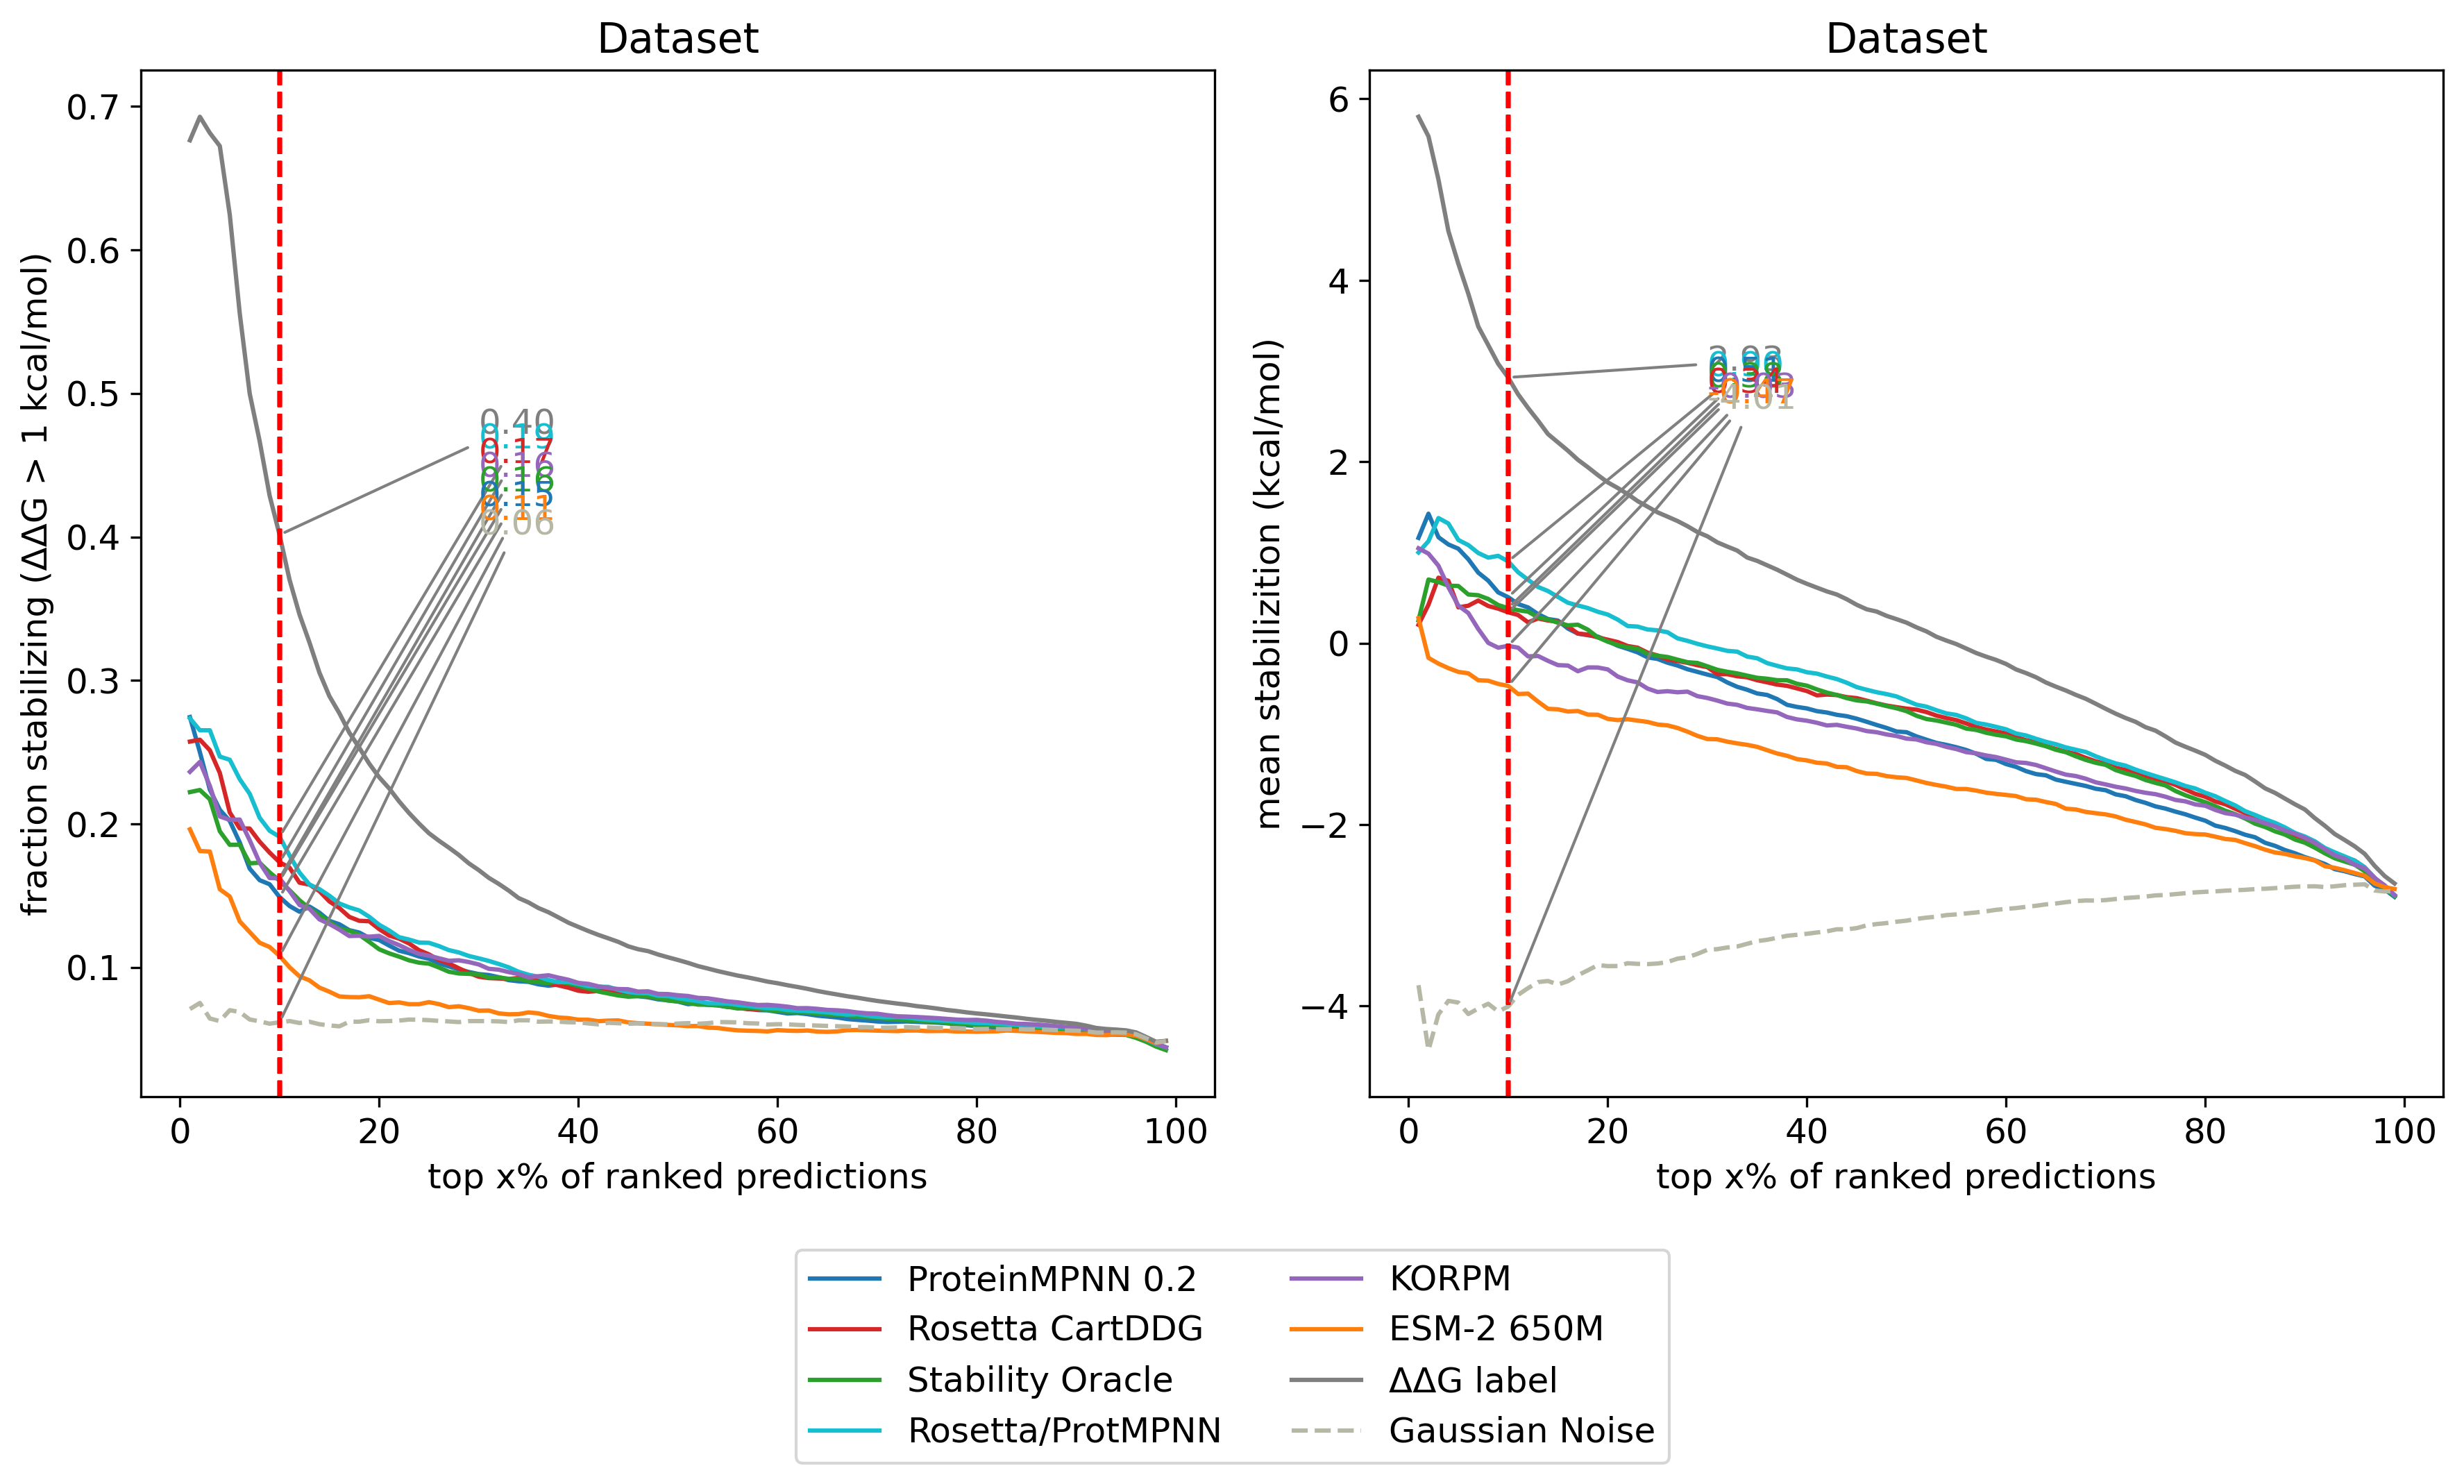

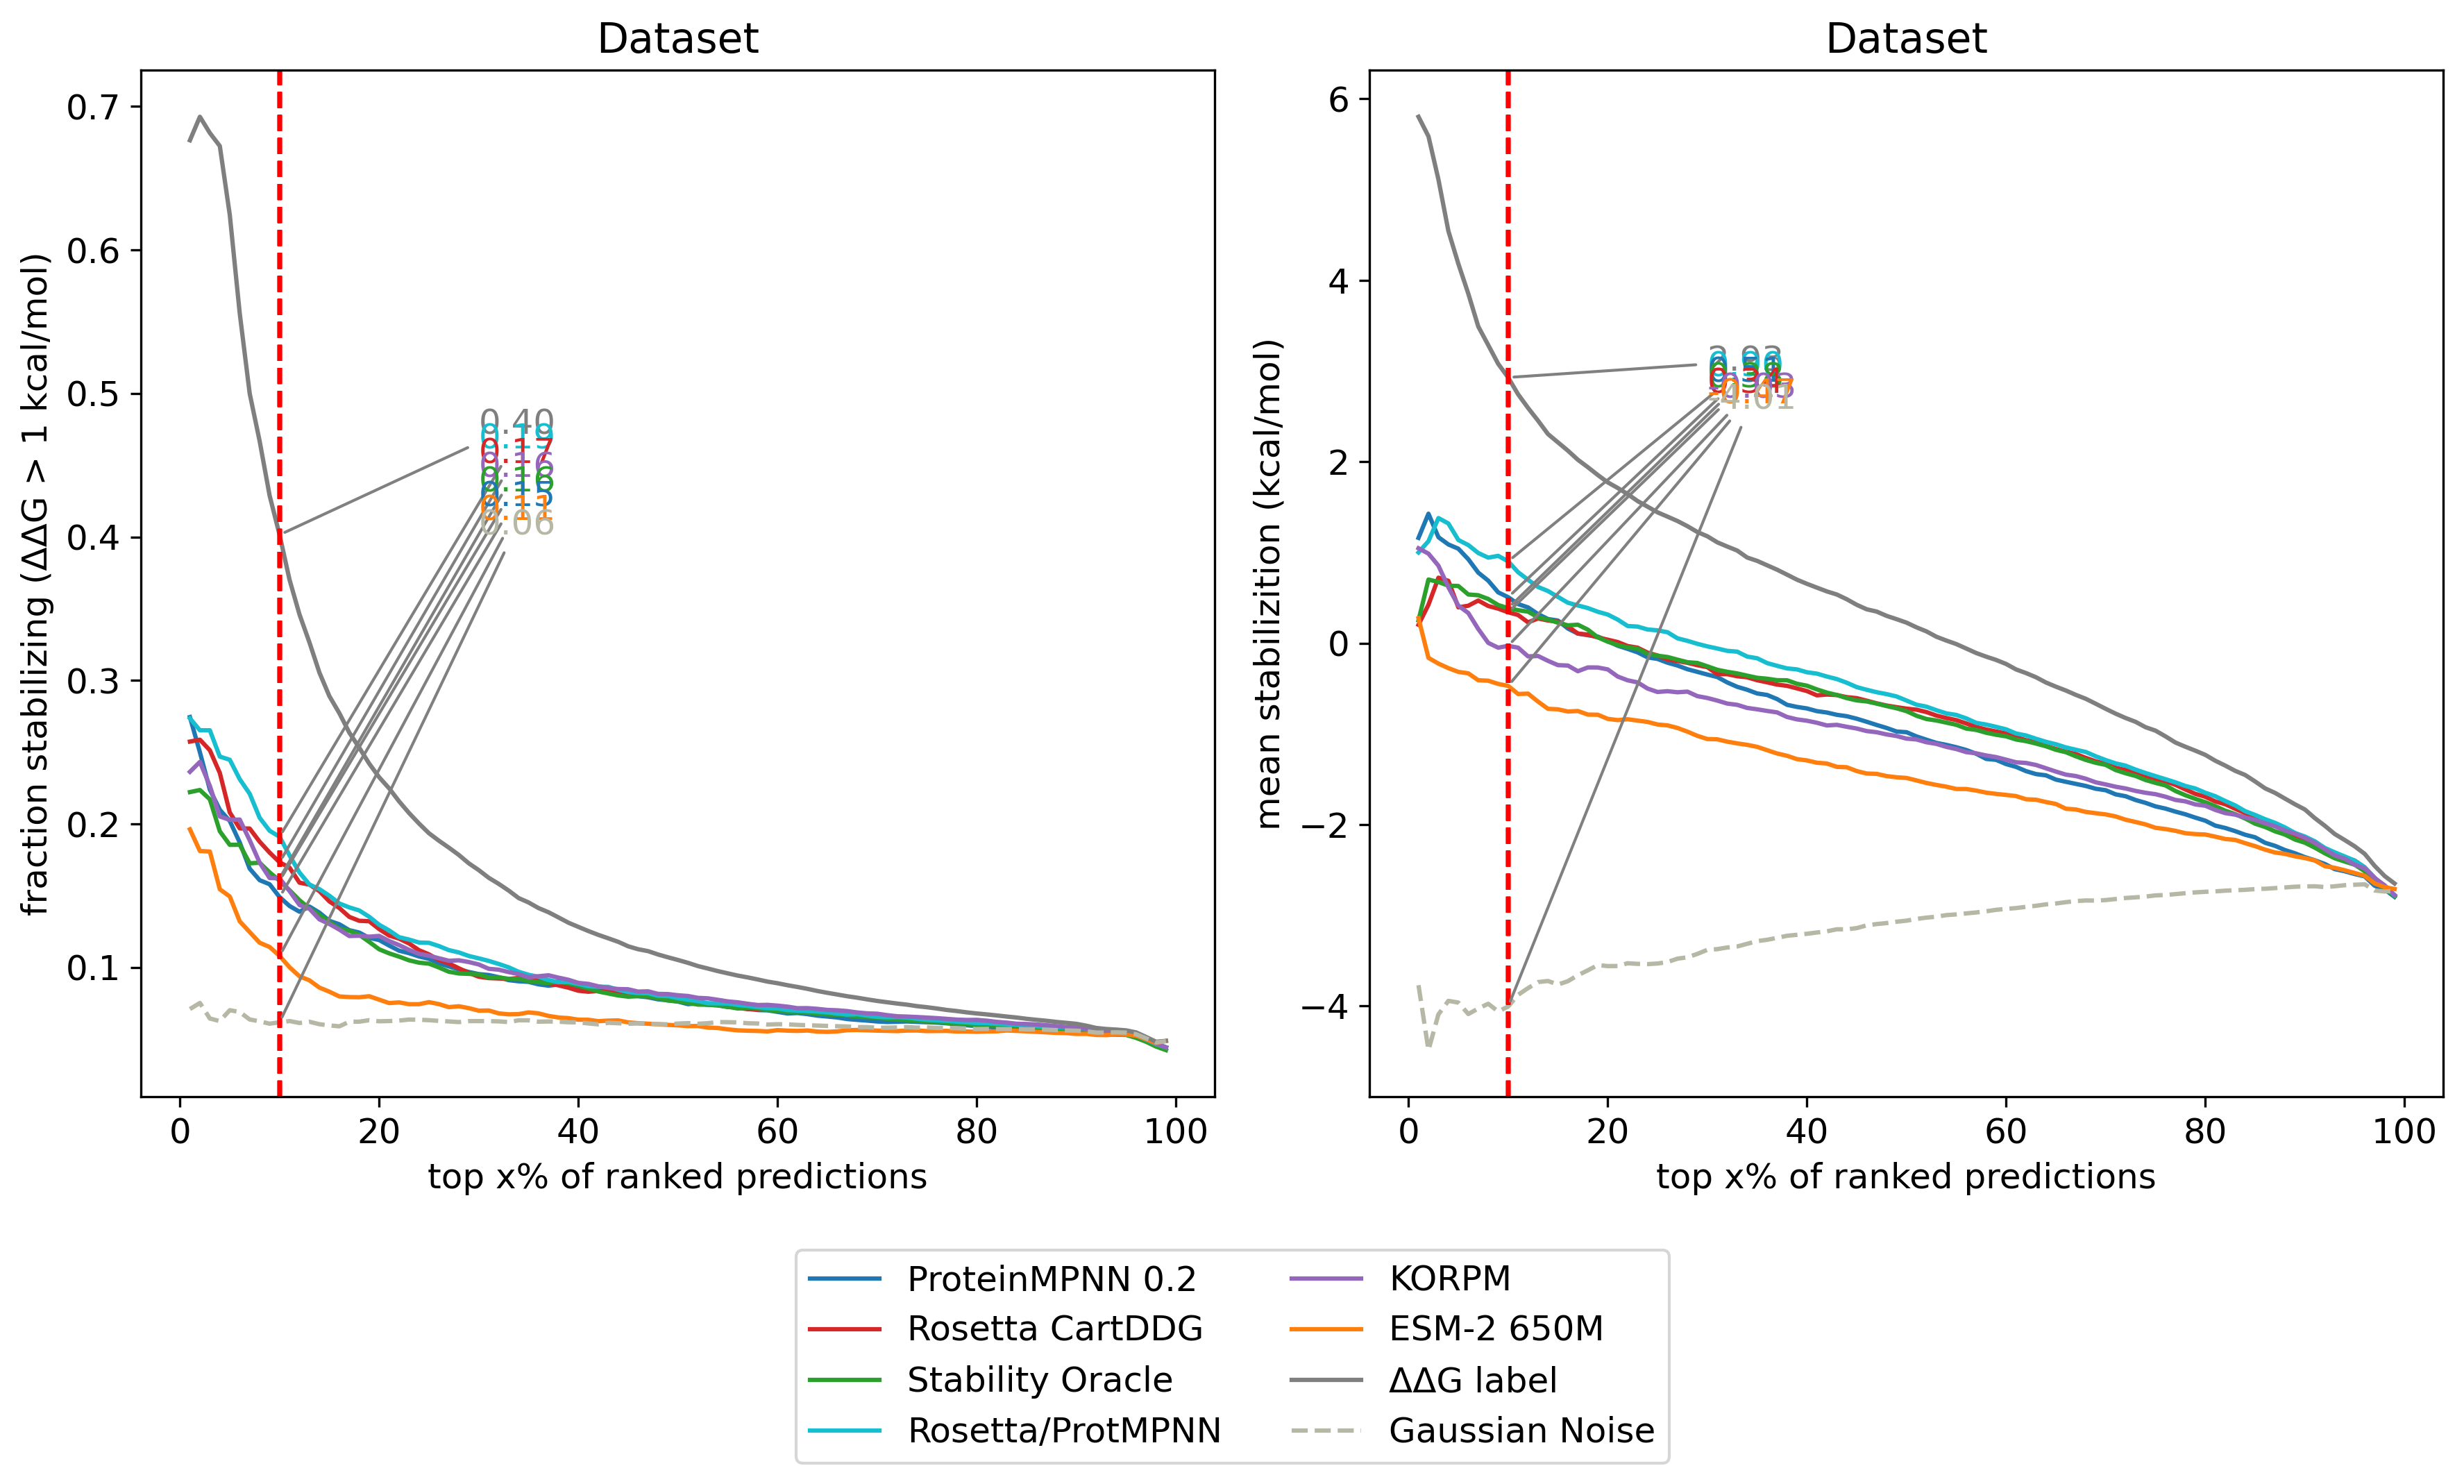

In [12]:
class_result_new = analysis_utils.compute_stats(db_class.drop('code', axis=1), stats=('aumsc', 'auppc'), measurements=['ddG'], grouper='cluster', n_bootstraps=0)
analysis_utils.recovery_curves(class_result_new, ['mpnn_20_00_dir', 'cartesian_ddg_dir', 'stability-oracle_dir', 'mpnn_rosetta_dir', 'korpm_dir', 'esm2_650M_dir', 'ddG_dir', 'random_dir'],  measurements=['ddG'], plots=['auppc', 'aumsc']) #'mif_dir', 'esmif_multimer_full_dir',

In [14]:
# SUPPLEMENTARY FIGURE 1 (second figure generated)

#db_corr = db_class.join(db_measurements)

db_class_ = db_class.copy(deep=True)
db_class_['code'] = db_class_.index.str[:4]
analysis_utils.correlations(db_class_, db_runtimes, stat='spearman', 
    score_name='mpnn_mean_dir', score_name_2='cartesian_ddg_dir', min_obs=1, group=True, plot=True, out=True, runtime=True)

KeyError: "[None, 'mpnn_mean_dir'] not in index"

In [ ]:
# SUPPLEMENTARY TABLE 3

tmp3_ = analysis_utils.compute_stats(db_class.drop('code', axis=1), stats=['tp', 'fp', 'tn', 'fn', 'mean_t1s', 'auppc', 'aumsc', 'mean_stabilization', 'net_stabilization'], grouper='cluster')
#tmp_.to_csv('~/zs_suppl/fireprot_enrichment_all.csv')
tmp3 = tmp3_.sort_values(['measurement', 'net_stabilization'], ascending=False).reset_index()

tmp3['model'] = tmp3['model'].map(remap_names_2)
tmp3['measurement'] = tmp3['measurement'].map({'ddG': 'ΔΔG', 'dTm': 'ΔTm'})
tmp3.loc[tmp3['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'tp': 'TP', 'fp': 'FP', 'tn': 'TN', 'fn': 'FN', 'mean_t1s': 'Mean Top-1 Score', 'auppc': 'AUPPC', 'aumsc': 'AUMSC', 'mean_stabilization': 'Mean Stabilization', 'net_stabilization': 'Net Stabilization'}
tmp3 = tmp3.rename(remap_cols, axis=1)
tmp3 = tmp3.drop('runtime', axis=1)
tmp3 = tmp3.drop('class', axis=1)
tmp3 = tmp3.drop([c for c in tmp3.columns if '$' in c or 'x_recovery' in c], axis=1)
tmp3 = tmp3.loc[tmp3['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)',
                            'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 'ESM-1V_2', 'Gaussian noise', 'ΔΔG label', 'ΔTm label'])]
tmp3 = tmp3.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp3 = tmp3[['TP', 'FP', 'TN', 'FN', 'AUPPC', 'AUMSC', 'Mean Top-1 Score', 'Mean Stabilization', 'Net Stabilization']]
#tmp3.to_csv('~/zs_suppl/fireprot_enrichment_select.csv')
tmp3
# ~ 3 minutes

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

TP     FP      TN      FN  AUPPC  \
measurement model_type   model                                               
ΔΔG         unknown      ΔΔG label    1069.0    0.0  2911.0     0.0  0.155   
                         ΔTm label     198.0   48.0   678.0    44.0  0.162   
            structural   MIF-ST        165.0  142.0  2769.0   904.0  0.070   
                         ESM-IF        215.0  172.0  2739.0   854.0  0.076   
            evolutionary Tranception    55.0   50.0  2861.0  1014.0  0.051   
            structural   ESM-IF(M)     209.0  177.0  2734.0   860.0  0.075   
                         MIF           252.0  250.0  2661.0   817.0  0.082   
            potential    KORPM         489.0  553.0  2358.0   580.0  0.081   
ΔTm         unknown      ΔTm label     394.0    0.0   936.0     0.0  0.463   
                         ΔΔG label     198.0   44.0   678.0    48.0  0.391   
            structural   ESM-IF        118.0   75.0   861.0   276.0  0.308   
                         ESM-IF(M)     115.0   70.0   866.0   279.0  0.309   
                         MIF-ST        105.0   83.0   853.0   289.0  0.300   
                         MIF           148.0  112.0   824.0   246.0  0.313   
            evolutionary Tranception    71.0   55.0   881.0   323.0  0.257   
            potential    KORPM         196.0  218.0   718.0   198.0  0.315   

                                      AUMSC  Mean Top-1 Score  \
measurement model_type   model                                  
ΔΔG         unknown      ΔΔG label    0.166             2.097   
                         ΔTm label    0.065             1.155   
            structural   MIF-ST      -0.442             0.005   
                         ESM-IF      -0.408             0.102   
            evolutionary Tranception -0.592            -0.096   
            structural   ESM-IF(M)   -0.411             0.080   
                         MIF         -0.410             0.253   
            potential    KORPM       -0.459             0.175   
ΔTm         unknown      ΔTm label    1.083             7.028   
                         ΔΔG label    0.301             5.045   
            structural   ESM-IF      -1.048             2.161   
                         ESM-IF(M)   -1.067             2.185   
                         MIF-ST      -1.421             1.316   
                         MIF         -1.325             1.834   
            evolutionary Tranception -2.237            -0.388   
            potential    KORPM       -1.519             0.547   

                                      Mean Stabilization  Net Stabilization  
measurement model_type   model                                               
ΔΔG         unknown      ΔΔG label                 0.706            754.610  
                         ΔTm label                 0.670            164.875  
            structural   MIF-ST                    0.101             31.000  
                         ESM-IF                    0.049             19.090  
            evolutionary Tranception               0.180             18.935  
            structural   ESM-IF(M)                -0.005             -1.855  
                         MIF                      -0.032            -16.015  
            potential    KORPM                    -0.193           -201.270  
ΔTm         unknown      ΔTm label                 3.376           1330.095  
                         ΔΔG label                 2.999            725.705  
            structural   ESM-IF                    2.131            411.280  
                         ESM-IF(M)                 2.079            384.690  
                         MIF-ST                    0.985            185.195  
                         MIF                       0.684            177.965  
            evolutionary Tranception              -0.113            -14.185  
            potential    KORPM                    -0.509           -210.525

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'mpnn_20_00_dir', 'mif_dir', 'korpm_dir', 'esmif_mean_dir', 'mifst_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'esm2_650M_dir', 'msa_transformer_mean_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
0 >= ΔΔG > -1.5    1239
ΔΔG <= -1.5         795
ΔΔG > 0             679
Name: n, dtype: int64


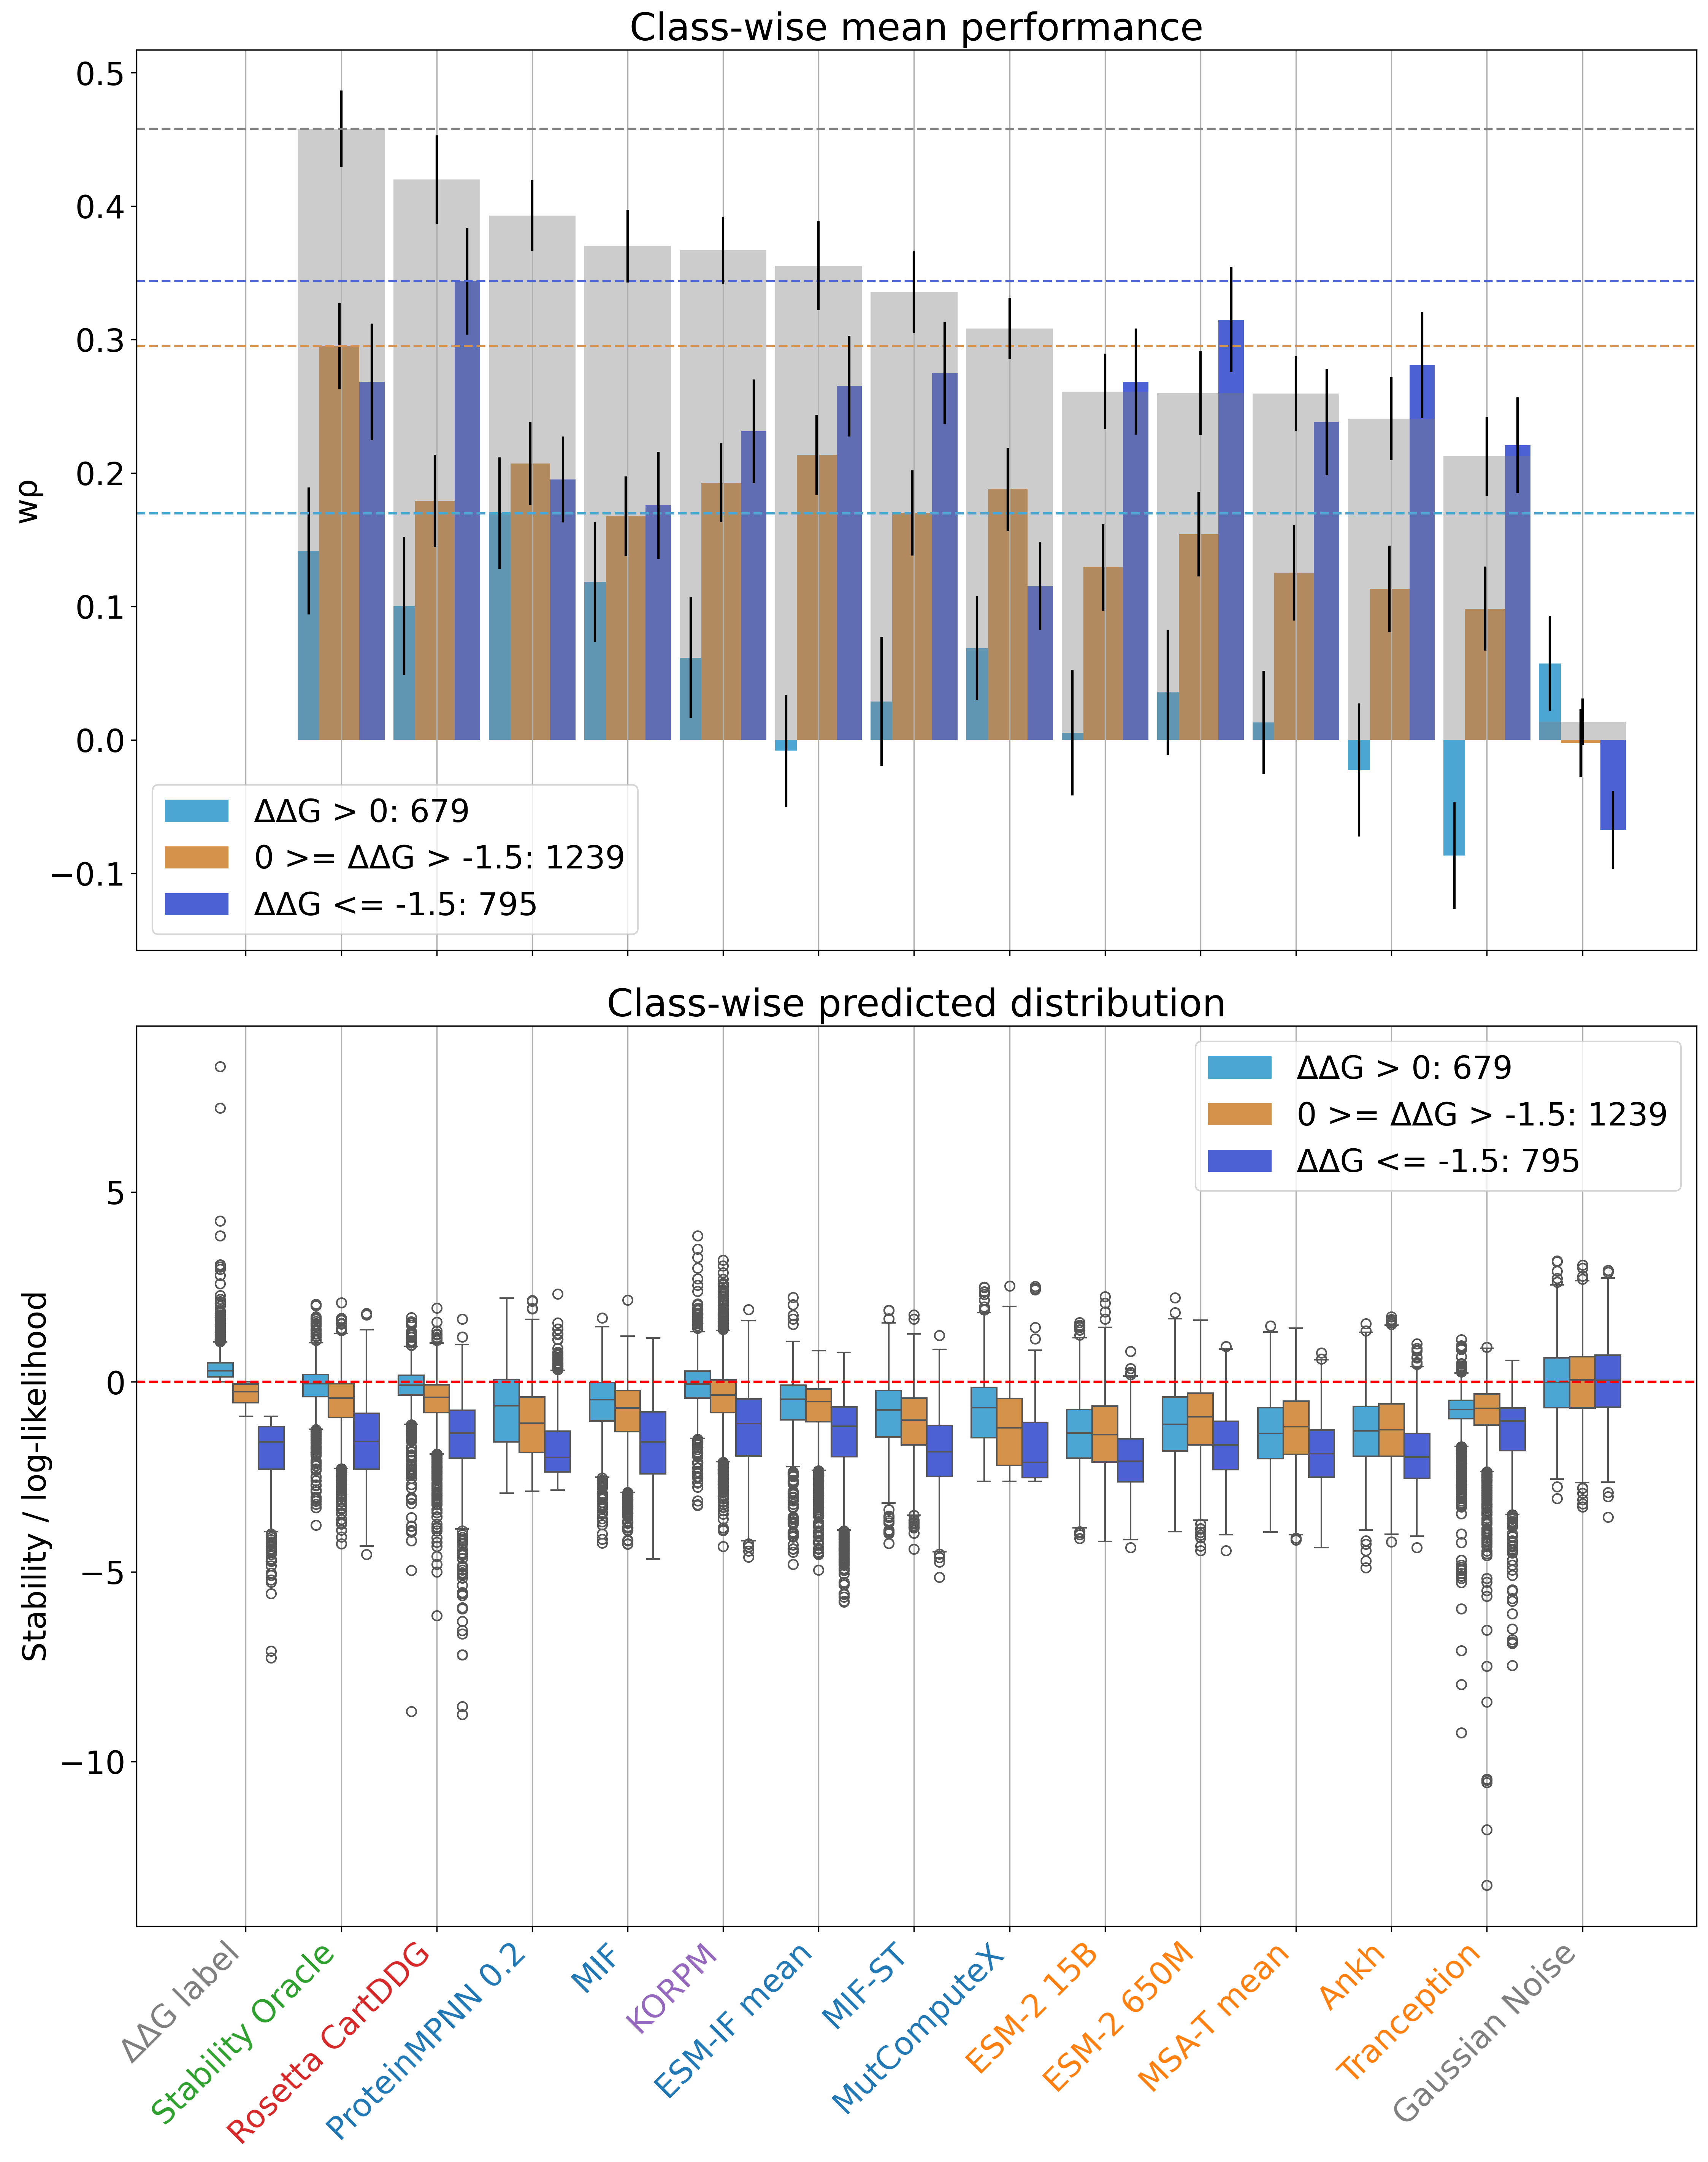

In [ ]:
# Todo: bootstrap by adding / removing proteins?
# Figure 1 a + b

custom_colors = {'cartesian_ddg_dir': 'orange',
                 'korpm_dir': 'orange',
                 #'esm1v_mean_dir': 'blue',
                 #'structural_dir': 'red',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 #'evolutionary_dir': 'green',
                 'esm2_650M_dir': 'blue',
                 'esm2_15B_half_dir': 'blue',
                 #'esm2_150M_dir': 'blue',
                 'ankh_dir': 'blue',
                 #'esmif_monomer_dir': 'red',
                 'esmif_mean_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 #'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 #'mpnn_mean_dir': 'red',
                 #'mif_mean_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'red',
                 'mutcomputex_dir': 'red',
                 'stability-oracle_dir': 'orange',
                 #'mifst_dir': 'purple',
                 'random_dir': 'grey',
                 'ddG_dir': 'grey'}

db_complete = db_class.join(db_feats_2.drop(['ProTherm', 'FireProt', 'ThermoFluor', 'is_curated'], axis=1), how='left')
db_complete['ddG_dir'] = db_complete['ddG']
db_complete['ΔΔG'] = db_complete['ddG']
#db_complete = db_complete.loc[~db_complete['ProTherm'].astype(bool)]

current_feats = ['ΔΔG', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'ΔΔG', 
                        split_col_2 = None, 
                        threshold_1 = 0, 
                        threshold_2 = -1.5, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster'
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'mpnn_20_00_dir', 'mif_dir', 'korpm_dir', 'esmif_mean_dir', 'mifst_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'msa_transformer_mean_dir', 'esm2_650M_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
1 >= delta_vol > -1     710
delta_vol <= -1        1353
delta_vol > 1           602
Name: n, dtype: int64


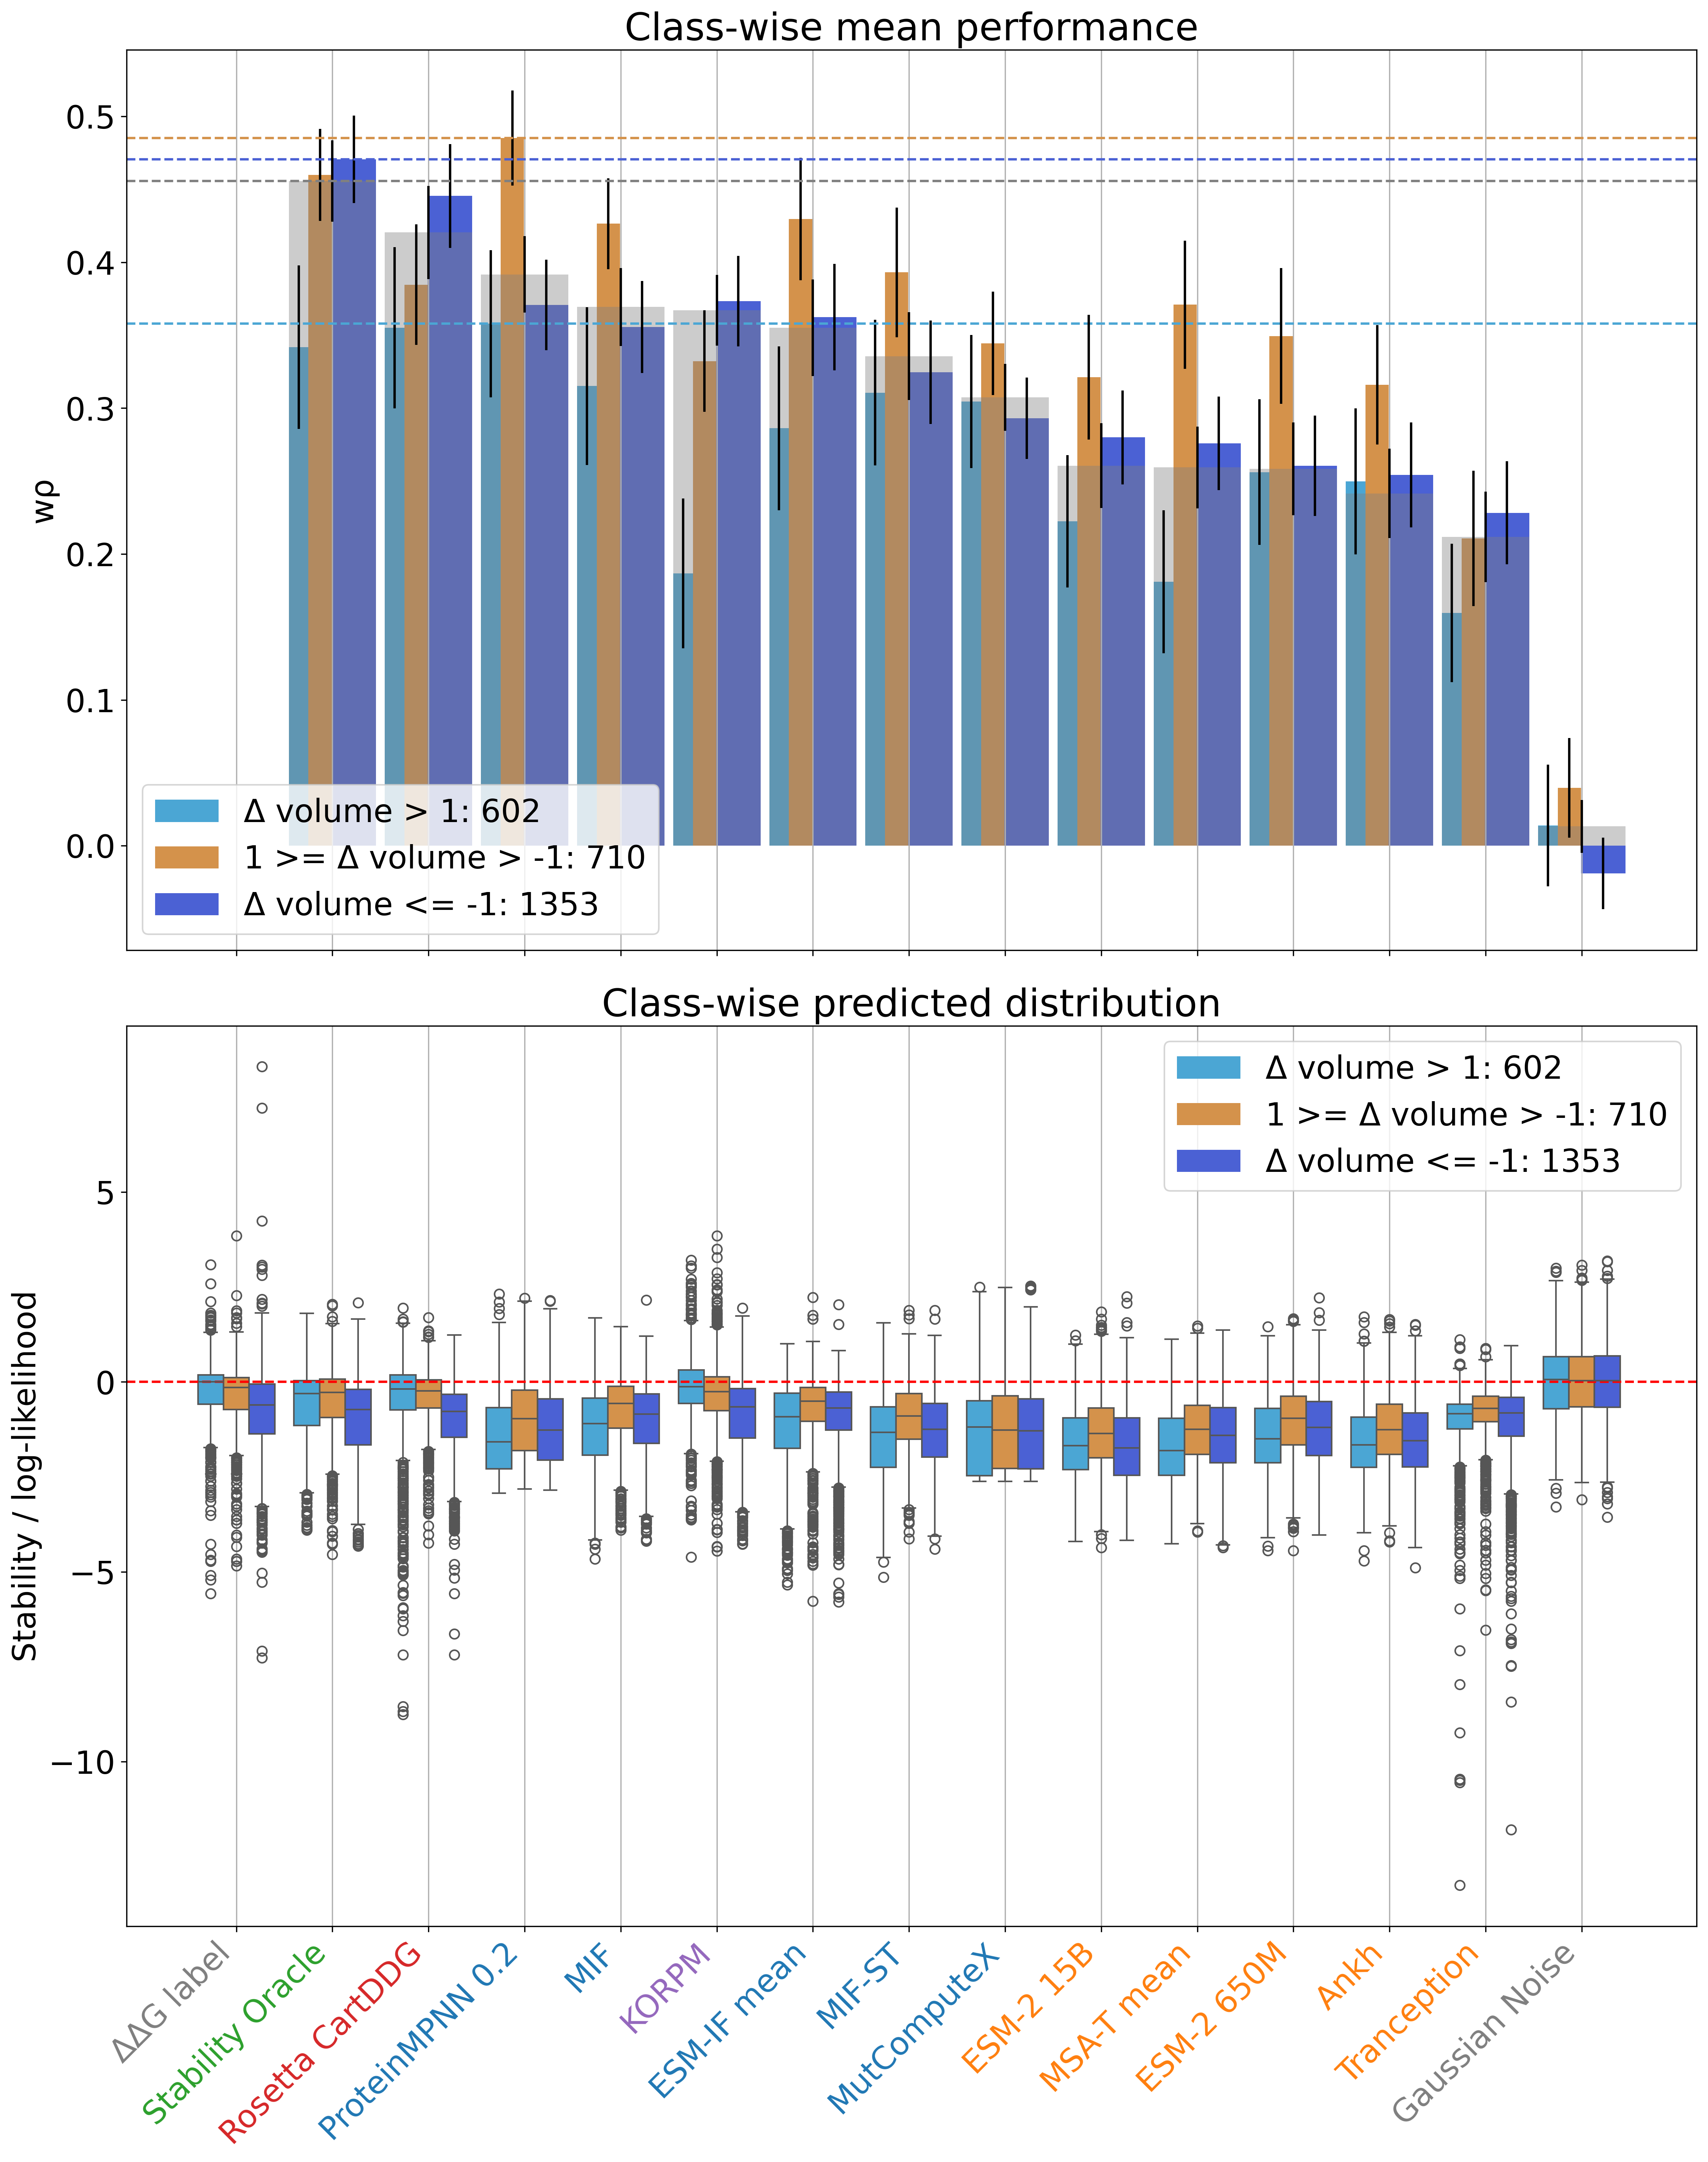

In [ ]:
# Figure 1 c + d

current_feats = ['delta_vol', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'delta_vol', 
                        split_col_2 = None, 
                        threshold_1 = 1, 
                        threshold_2 = -1, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster'
                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'mpnn_20_00_dir', 'mif_dir', 'korpm_dir', 'esmif_mean_dir', 'mifst_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'msa_transformer_mean_dir', 'esm2_650M_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
delta_kdh <= 0 & rel_ASA <= 0.1     531
delta_kdh <= 0 & rel_ASA > 0.1      752
delta_kdh > 0 & rel_ASA <= 0.1      348
delta_kdh > 0 & rel_ASA > 0.1      1069
Name: n, dtype: int64


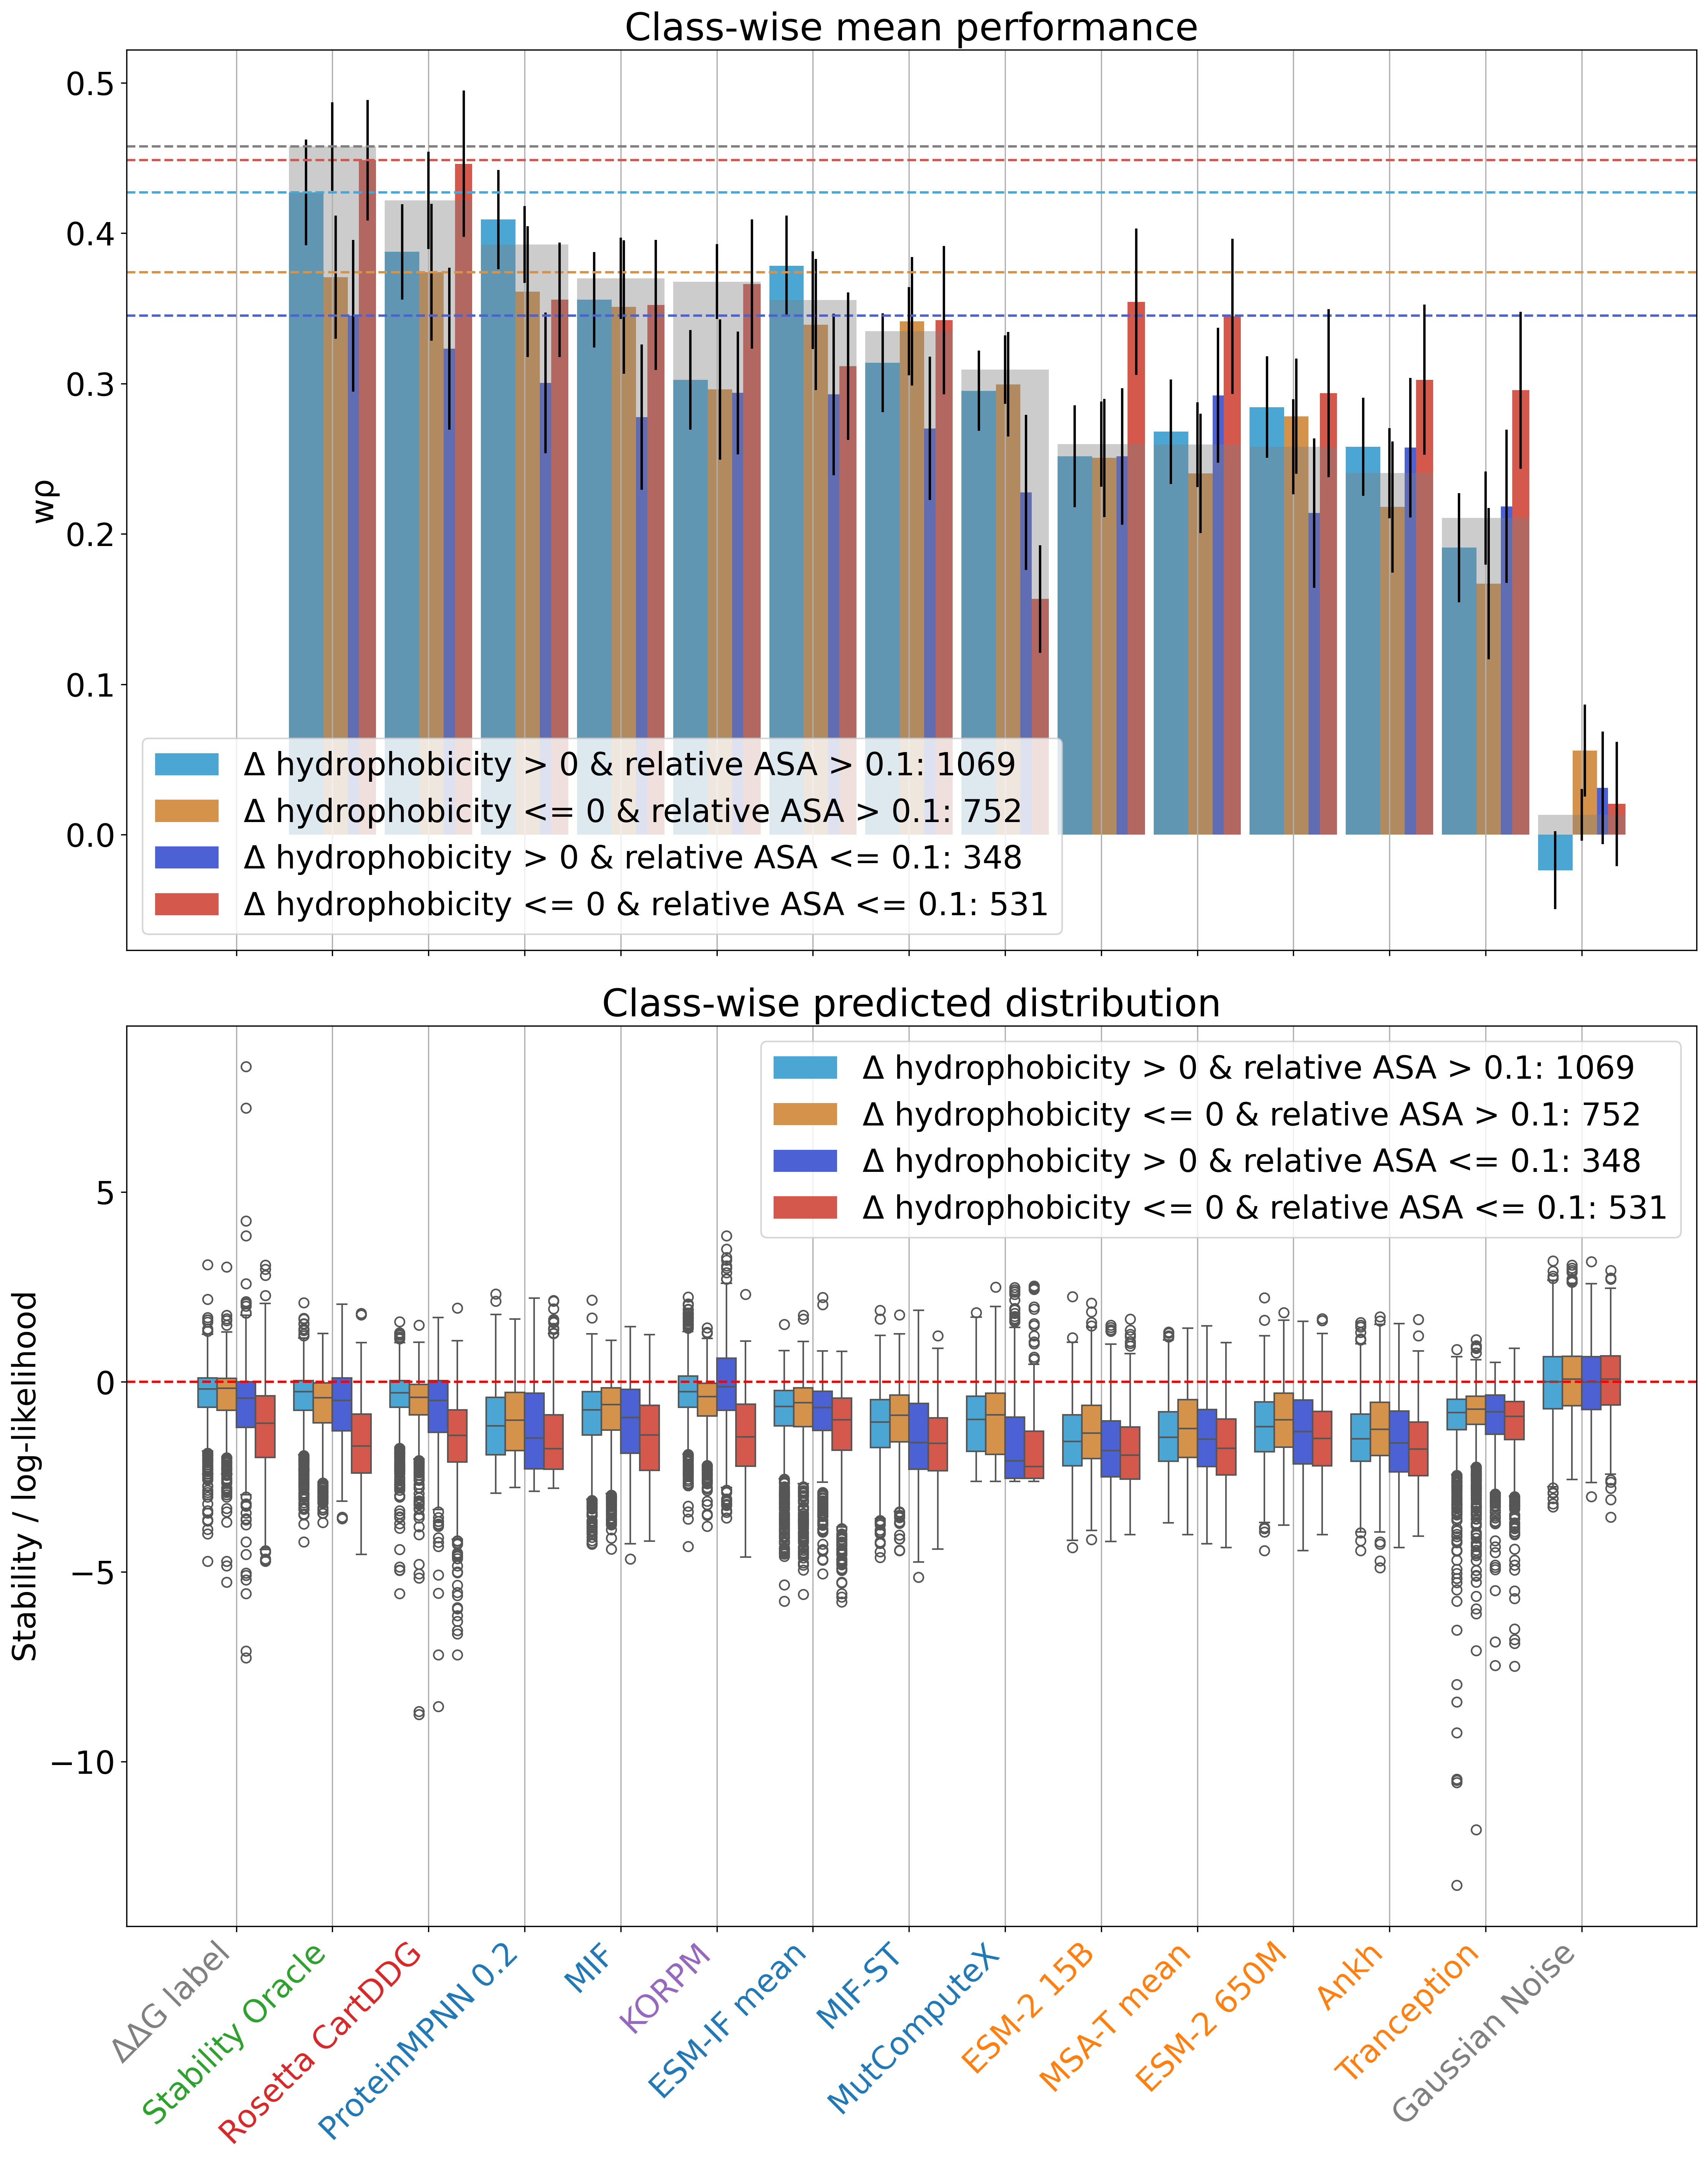

In [ ]:
# Supplementary Figure 2

current_feats = ['delta_kdh', 'rel_ASA', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'delta_kdh', 
                        split_col_2 = 'rel_ASA', 
                        threshold_1 = 0, 
                        threshold_2 = 0.1, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster')

  0%|          | 0/1000 [00:00<?, ?it/s]

conservation > 80% : 488
conservation <= 80% : 2228
['ddG_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'mpnn_20_00_dir', 'mif_dir', 'korpm_dir', 'esmif_mean_dir', 'mifst_dir', 'mutcomputex_dir', 'esm2_15B_half_dir', 'msa_transformer_mean_dir', 'esm2_650M_dir', 'ankh_dir', 'tranception_dir', 'random_dir']
class
conservation <= 80    2228
conservation > 80      488
Name: n, dtype: int64


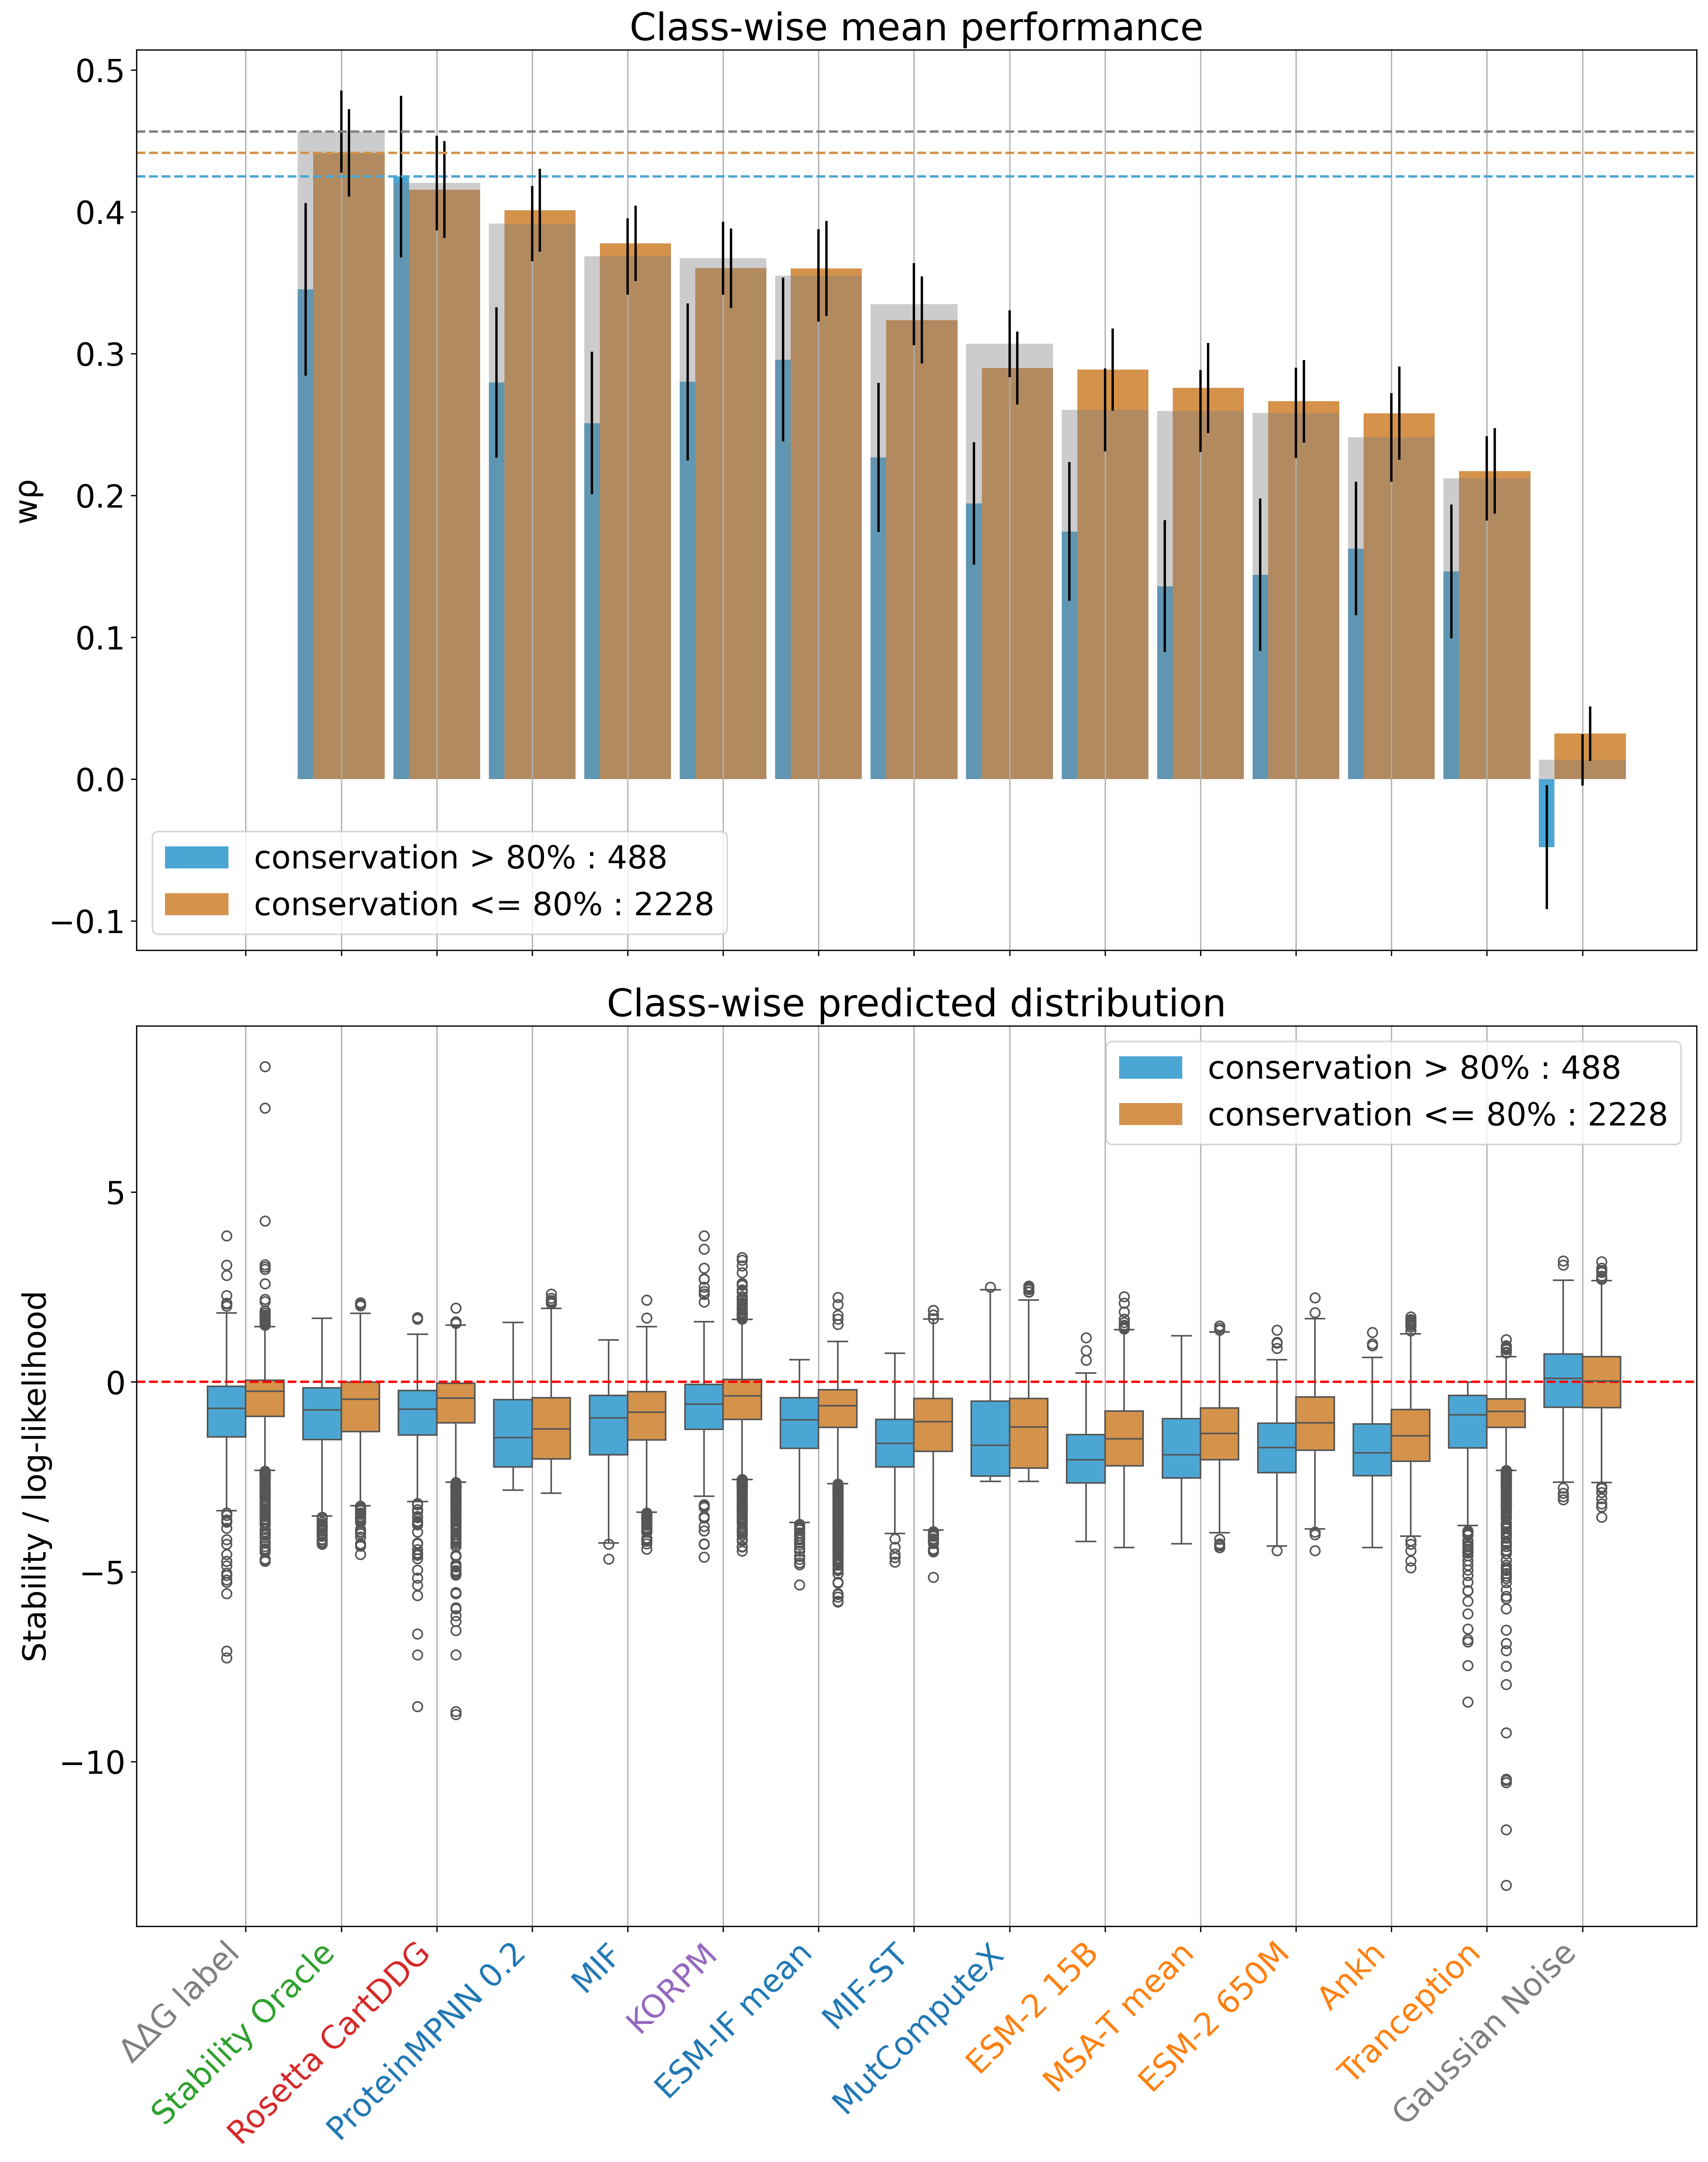

In [ ]:
# Supplementary Figure 3

current_feats = ['conservation', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'conservation', 
                        split_col_2 = None, 
                        threshold_1 = 80, 
                        threshold_2 = None, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster')

  0%|          | 0/1000 [00:00<?, ?it/s]

['ddG_dir', 'cartesian_ddg_dir', 'mpnn_mean_dir', 'mif_dir', 'korpm_dir', 'esmif_multimer_dir', 'mifst_dir', 'msa_transformer_mean_dir', 'esm1v_mean_dir', 'tranception_dir']
class
is_nmr <= 0.5    2357
is_nmr > 0.5      283
Name: n, dtype: int64


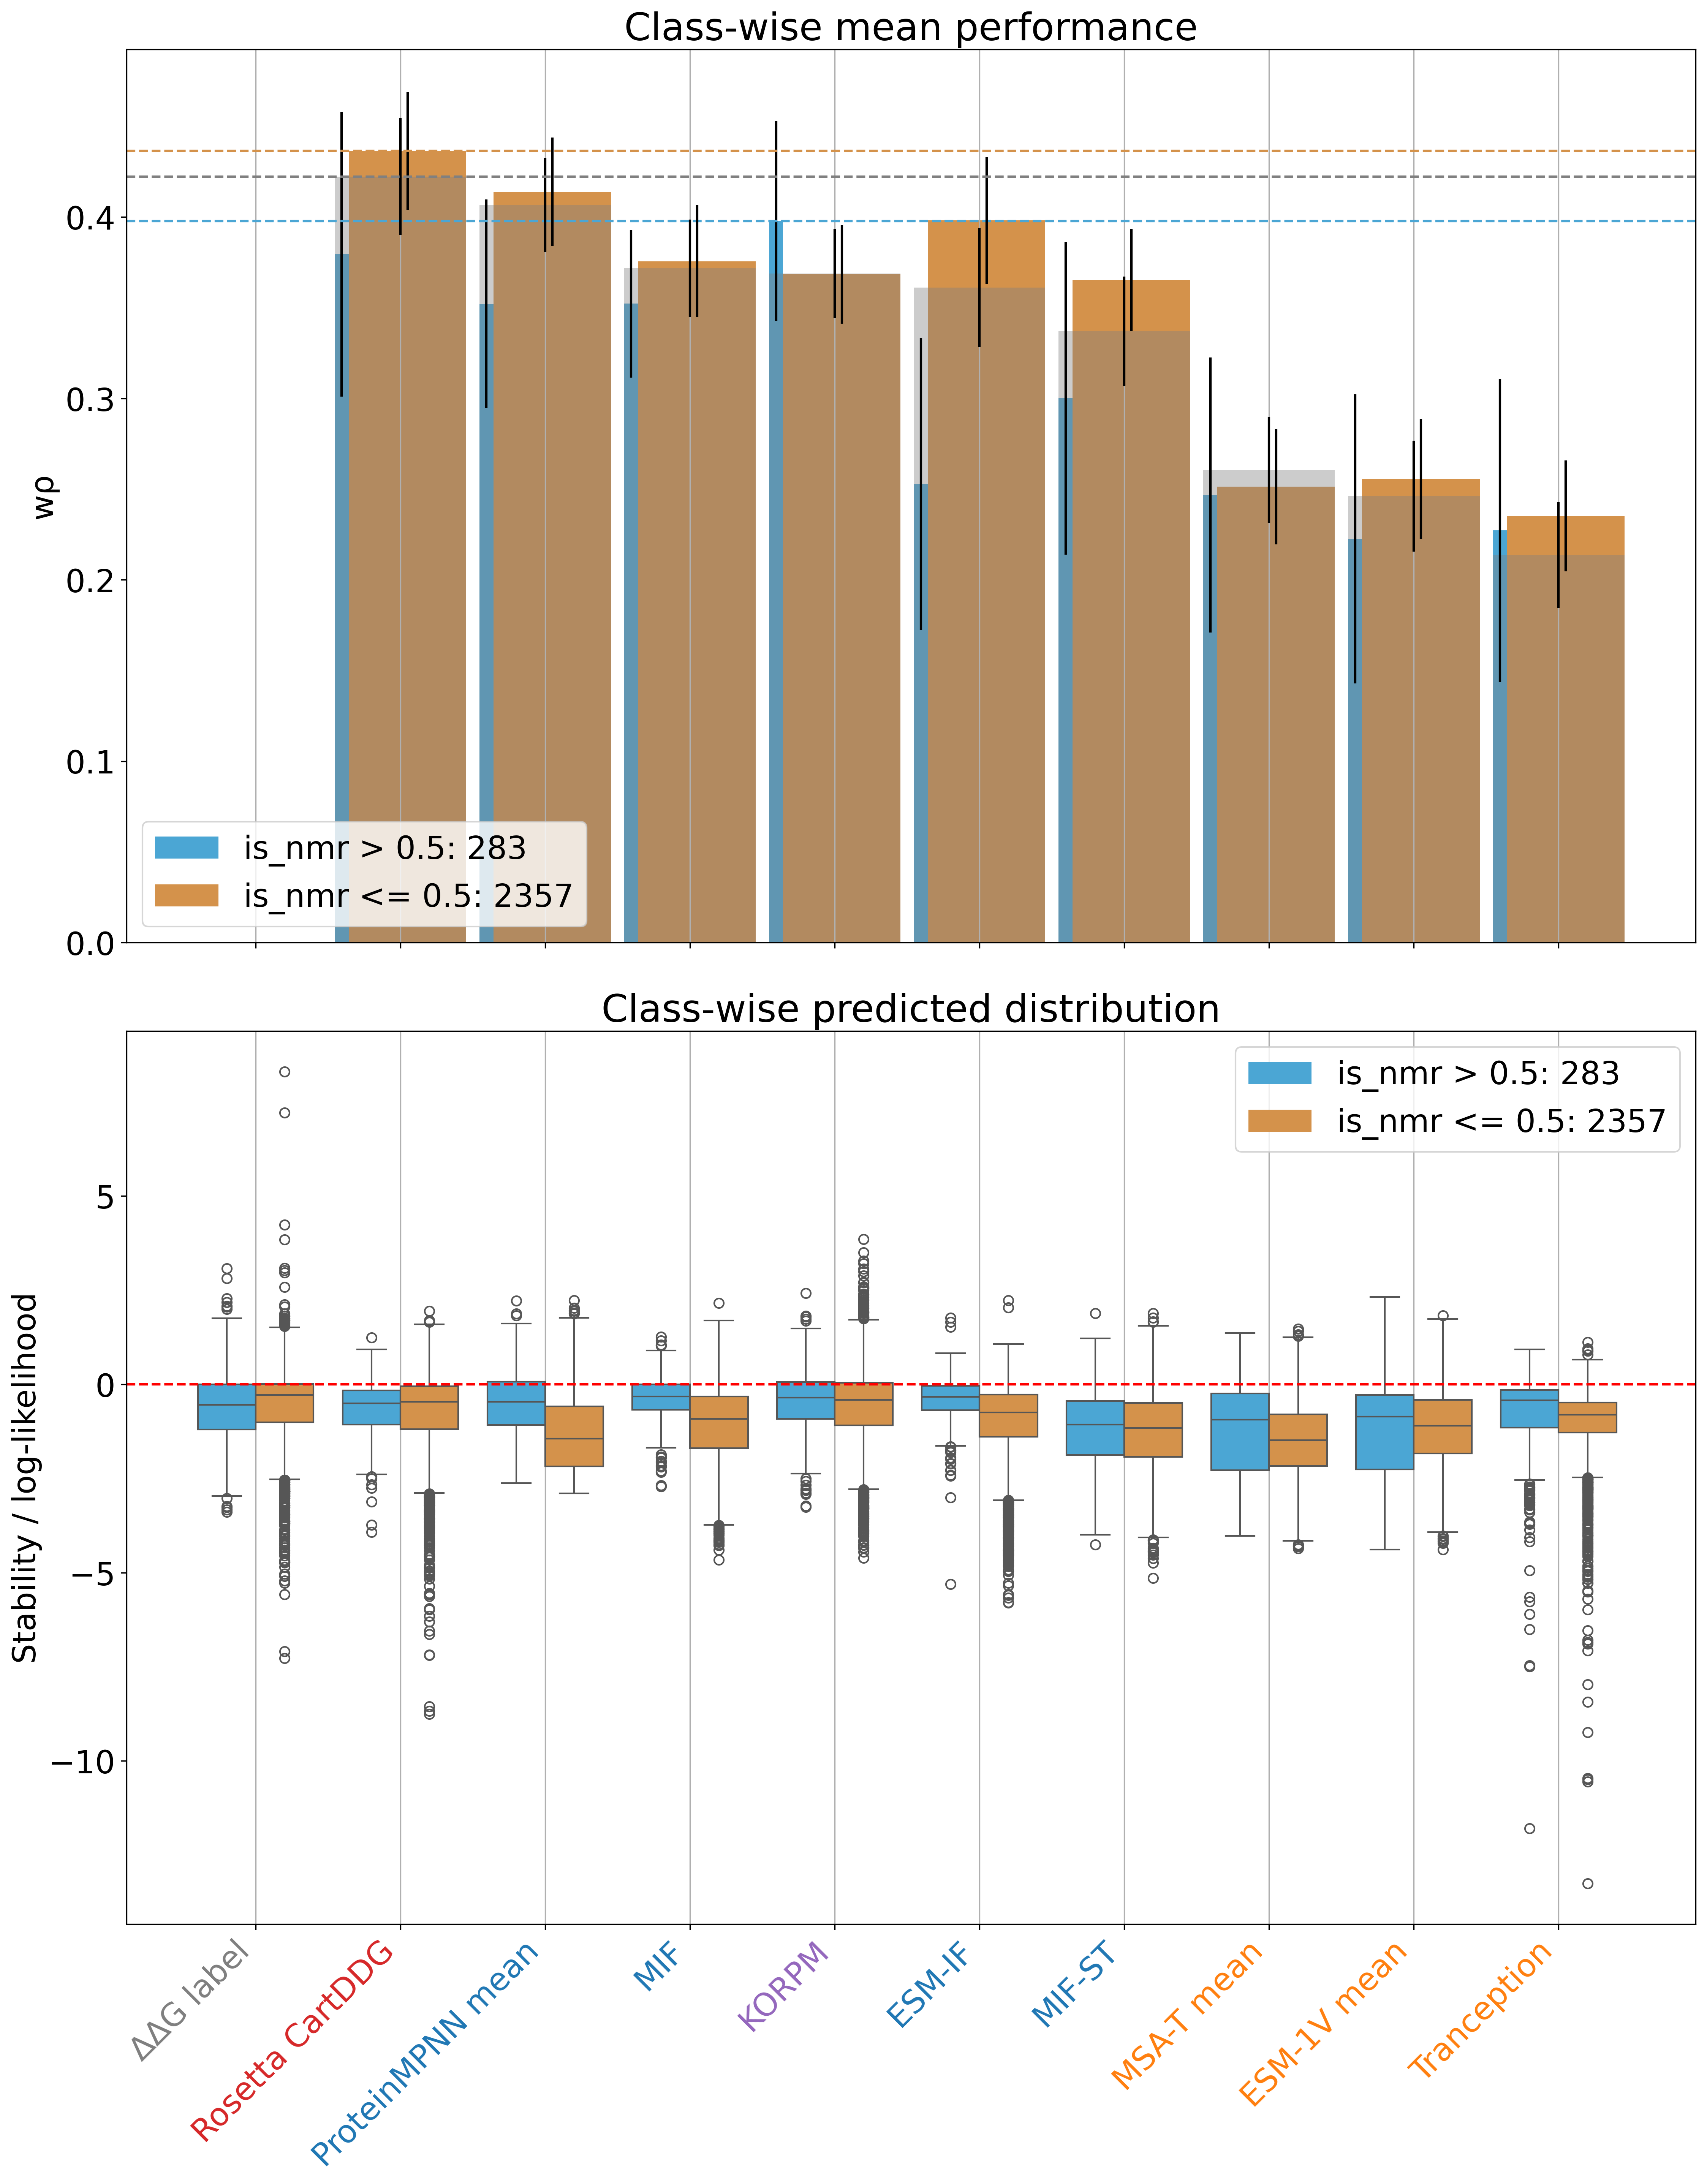

In [ ]:
custom_colors = {'cartesian_ddg_dir': 'red',
                 'korpm_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'msa_transformer_mean_dir': 'green',
                 'tranception_dir': 'green',
                 #'esmif_monomer_dir': 'red',
                 'esmif_multimer_dir': 'red',
                 #'esmif_monomer_masked_dir': 'red',
                 'mpnn_mean_dir': 'red',
                 #'mpnn_10_00_dir': 'red',
                 #'mpnn_20_00_dir': 'red',
                 #'mpnn_30_03_dir': 'red',
                 #'mpnn_30_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 'ddG_dir': 'grey'}
                 
current_feats = ['is_nmr', 'ddG']
db_fig = db_complete[[c for c in db_complete if '_dir' in c or c in current_feats or c == 'cluster']].fillna(0)
d = analysis_utils.compare_performance(
                        db_fig,
                        split_col = 'is_nmr', 
                        split_col_2 = None, 
                        threshold_1 = 0.5, 
                        threshold_2 = None, 
                        measurement = 'ddG',
                        statistic = 'spearman',
                        statistic_2 = 'weighted_spearman',
                        n_bootstraps=1000,
                        count_muts = True,
                        subset = list(custom_colors.keys()),
                        grouper = 'cluster')

In [ ]:
# generate ensembles for Model Complementarity section

models = original_pred_cols_reduced + \
          ['rel_ASA_dir', 'delta_kdh_dir', 'delta_vol_dir', 'delta_chg_dir'] + \
            ['mpnn_mean_dir', 'esmif_mean_dir', 'esm2_mean_dir', 'mif_mean_dir']
#models = ['mpnn_20_00_dir', 'cartesian_ddg_dir', 'esm2_dir']

zs_feats = ['rel_ASA', 'delta_kdh', 'delta_vol', 'delta_chg']

db_summ = db_class.join(db_feats_2[zs_feats])#.join(db_clusters).join(db_ddg)#.drop('code', axis=1)
print(len(db_summ))
#db_summ = db_summ.loc[~db_summ['ProTherm'].astype(bool)]
#db_summ = db_summ.loc[db_summ['is_curated'].astype(bool)]
db_summ = db_summ.dropna(subset='cartesian_ddg_dir')
print(len(db_summ))
db_summ['ddG_dir'] = db_summ['ddG']
db_summ['dTm_dir'] = db_summ['dTm']
#db_summ['delta_vol_dir'] = db_summ['delta_vol'].transform(lambda x: -np.abs(x))
#db_summ['delta_kdh_dir'] = db_summ['delta_kdh'].transform(lambda x: -np.abs(x))
#db_summ['delta_chg_dir'] = db_summ['delta_chg'].transform(lambda x: -np.abs(x))
#db_summ['rel_ASA_dir'] = db_summ['rel_ASA']
db_summ['random_dir'] = np.random.normal(loc=0, size=len(db_summ))

dfm = db_summ#.join(db_feats_2[zs_feats].drop_duplicates(), how='left')
#dfm['code'] = dfm.index.str[:4]
ren = dict(zip(zs_feats, [f+'_dir' for f in zs_feats]))
dfm = dfm.rename(ren, axis=1)
#dfm = dfm.drop(['is_curated'], axis=1)
dfr = db_runtimes.copy(deep=True)
#dfr['code'] = dfr.index.str[:4]
dfr[['runtime_' + r for r in ['rel_ASA_dir', 'delta_kdh_dir', 'delta_vol_dir', 'delta_chg_dir']]] = 0

weights = [1, 0.5, 0.2] #, -0.2] # could include -0.2 to allow for subtracting models
weights2 = [] # fill in weights to test 3-model ensembles
#weights2 = [0.8, 0.3]

all_cols = []

tmp_preds = []
tmp_runtimes = []
for model1 in models:
    for model2 in models:
        if model1 != model2:
            for weight in weights:
                tmp_preds.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                #tmp_preds.append(pd.Series((dfm[model1]-dfm[model1].min())/dfm[model1].max() + (dfm[model2]-dfm[model2].min())/dfm[model1].max() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #tmp_runtimes.append(pd.Series(dfr['runtime_'+model1] + dfr['runtime_'+model2], name=f'runtime_'+all_cols[-1]))
                for model3 in models:
                    #if (model1.split('_')[0] != model3.split('_')[0]) and (model2.split('_')[0] != model3.split('_')[0]):
                        for weight2 in weights2:
                            tmp_preds.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight + dfm[model3]/dfm[model3].std() * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                            #tmp_preds.append(pd.Series((dfm[model1]-dfm[model1].min())/dfm[model1].max() + (dfm[model2]-dfm[model2].min())/dfm[model2].max() * weight + (dfm[model3]-dfm[model3].min())/dfm[model3].max() * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')
                            #tmp_runtimes.append(pd.Series(dfr['runtime_'+model1] + dfr['runtime_'+model2] + dfr['runtime_'+model3], name='runtime_'+all_cols[-1]))

print('concatenating')
dfm = pd.concat([dfm] + tmp_preds, axis=1)
dfr = pd.concat([dfr] + tmp_runtimes, axis=1)
#print('saving...')
#dfm.to_csv('~/zs_suppl/preds_ensemble_fireprot_3_models.csv')
print('joining...')
dfm = dfm.join(dfr.drop('code', axis=1))

4342
4342
concatenating
joining...


In [ ]:
def get_summary_df(db_complete, cols=None, class_stats=(), saveloc='../../zeroshot suppl/fireprot_summary.csv', overwrite=False):

    if not overwrite:
        assert not os.path.exists(saveloc)
    if cols is None:
        cols = db_complete.columns
        for extra in ['code', 'ProTherm', 'FireProt', 'is_curated', 'ThermoFluor']:
            if extra in cols:
                cols = cols.drop(extra)

    df_summ = analysis_utils.compute_stats(db_complete[cols], stats=class_stats, grouper='cluster', measurements=['ddG']).reset_index().set_index(['measurement', 'model'])
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1)
    df_summ = df_summ.set_index(['measurement', 'model_type', 'model', 'class'])

    df_summ.to_csv(saveloc)
    return df_summ

In [ ]:
# compute all statistics on the combined set (already done, takes ~12 hours)
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'ensemble_fireprot_2_models_3_weights_revised_over_10_in_cluster_new.csv'), overwrite=True)
d1 = pd.read_csv(os.path.join(path, 'data', 'pairwise', 'pairwise_fp_combinations_3_weights.csv')).set_index(['measurement', 'model_type', 'model', 'class'])
d1.xs('ddG').sort_values('weighted_ndcg', ascending=False).iloc[:20, 13:]

auroc  \
model_type  model                                     class             
unknown     ddG_dir                                   NaN    1.000000   
            dTm_dir                                   NaN    0.943406   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 0.5   NaN    0.789848   
            cartesian_ddg_dir + mpnn_30_00_dir * 0.5  NaN    0.785957   
            cartesian_ddg_dir + mpnn_20_00_dir * 0.5  NaN    0.790104   
structural  mpnn_rosetta_dir                          NaN    0.793187   
potential   korpm_dir + mpnn_30_00_dir * 1            NaN    0.755436   
            mpnn_30_00_dir + korpm_dir * 1            NaN    0.755436   
biophysical cartesian_ddg_dir + mpnn_10_00_dir * 0.5  NaN    0.789124   
potential   korpm_dir + mpnn_mean_dir * 1             NaN    0.762663   
            mpnn_mean_dir + korpm_dir * 1             NaN    0.762663   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 1     NaN    0.772454   
            mpnn_mean_dir + cartesian_ddg_dir * 1     NaN    0.772454   
            mpnn_mean_dir + cartesian_ddg_dir * 0.5   NaN    0.751501   
            cartesian_ddg_dir + mpnn_20_00_dir * 1    NaN    0.772130   
            mpnn_20_00_dir + cartesian_ddg_dir * 1    NaN    0.772130   
            cartesian_ddg_dir + mpnn_10_00_dir * 0.2  NaN    0.796856   
transfer    mpnn_20_00_dir + stability-oracle_dir * 1 NaN    0.771729   
            stability-oracle_dir + mpnn_20_00_dir * 1 NaN    0.771729   
potential   mpnn_mean_dir + korpm_dir * 0.5           NaN    0.748090   

                                                                auprc  \
model_type  model                                     class             
unknown     ddG_dir                                   NaN    1.000000   
            dTm_dir                                   NaN    0.854619   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 0.5   NaN    0.568603   
            cartesian_ddg_dir + mpnn_30_00_dir * 0.5  NaN    0.560265   
            cartesian_ddg_dir + mpnn_20_00_dir * 0.5  NaN    0.569398   
structural  mpnn_rosetta_dir                          NaN    0.570926   
potential   korpm_dir + mpnn_30_00_dir * 1            NaN    0.523148   
            mpnn_30_00_dir + korpm_dir * 1            NaN    0.523148   
biophysical cartesian_ddg_dir + mpnn_10_00_dir * 0.5  NaN    0.566514   
potential   korpm_dir + mpnn_mean_dir * 1             NaN    0.529428   
            mpnn_mean_dir + korpm_dir * 1             NaN    0.529428   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 1     NaN    0.553707   
            mpnn_mean_dir + cartesian_ddg_dir * 1     NaN    0.553707   
            mpnn_mean_dir + cartesian_ddg_dir * 0.5   NaN    0.531601   
            cartesian_ddg_dir + mpnn_20_00_dir * 1    NaN    0.552843   
            mpnn_20_00_dir + cartesian_ddg_dir * 1    NaN    0.552843   
            cartesian_ddg_dir + mpnn_10_00_dir * 0.2  NaN    0.565993   
transfer    mpnn_20_00_dir + stability-oracle_dir * 1 NaN    0.536715   
            stability-oracle_dir + mpnn_20_00_dir * 1 NaN    0.536715   
potential   mpnn_mean_dir + korpm_dir * 0.5           NaN    0.520275   

                                                             0.0_n_stable  \
model_type  model                                     class                 
unknown     ddG_dir                                   NaN           755.0   
            dTm_dir                                   NaN           381.0   
biophysical cartesian_ddg_dir + mpnn_mean_dir * 0.5   NaN          1275.0   
            cartesian_ddg_dir + mpnn_30_00_dir * 0.5  NaN          1275.0   
            cartesian_ddg_dir + mpnn_20_00_dir * 0.5  NaN          1275.0   
structural  mpnn_rosetta_dir                          NaN          1275.0   
potential   korpm_dir + mpnn_30_00_dir * 1            NaN          1275.0   
            mpnn_30_00_dir + korpm_dir * 1            NaN          1275.0   
biophysical cartesian_ddg_dir + mpnn_10_00_dir * 0.5  NaN          1275.0   
pot

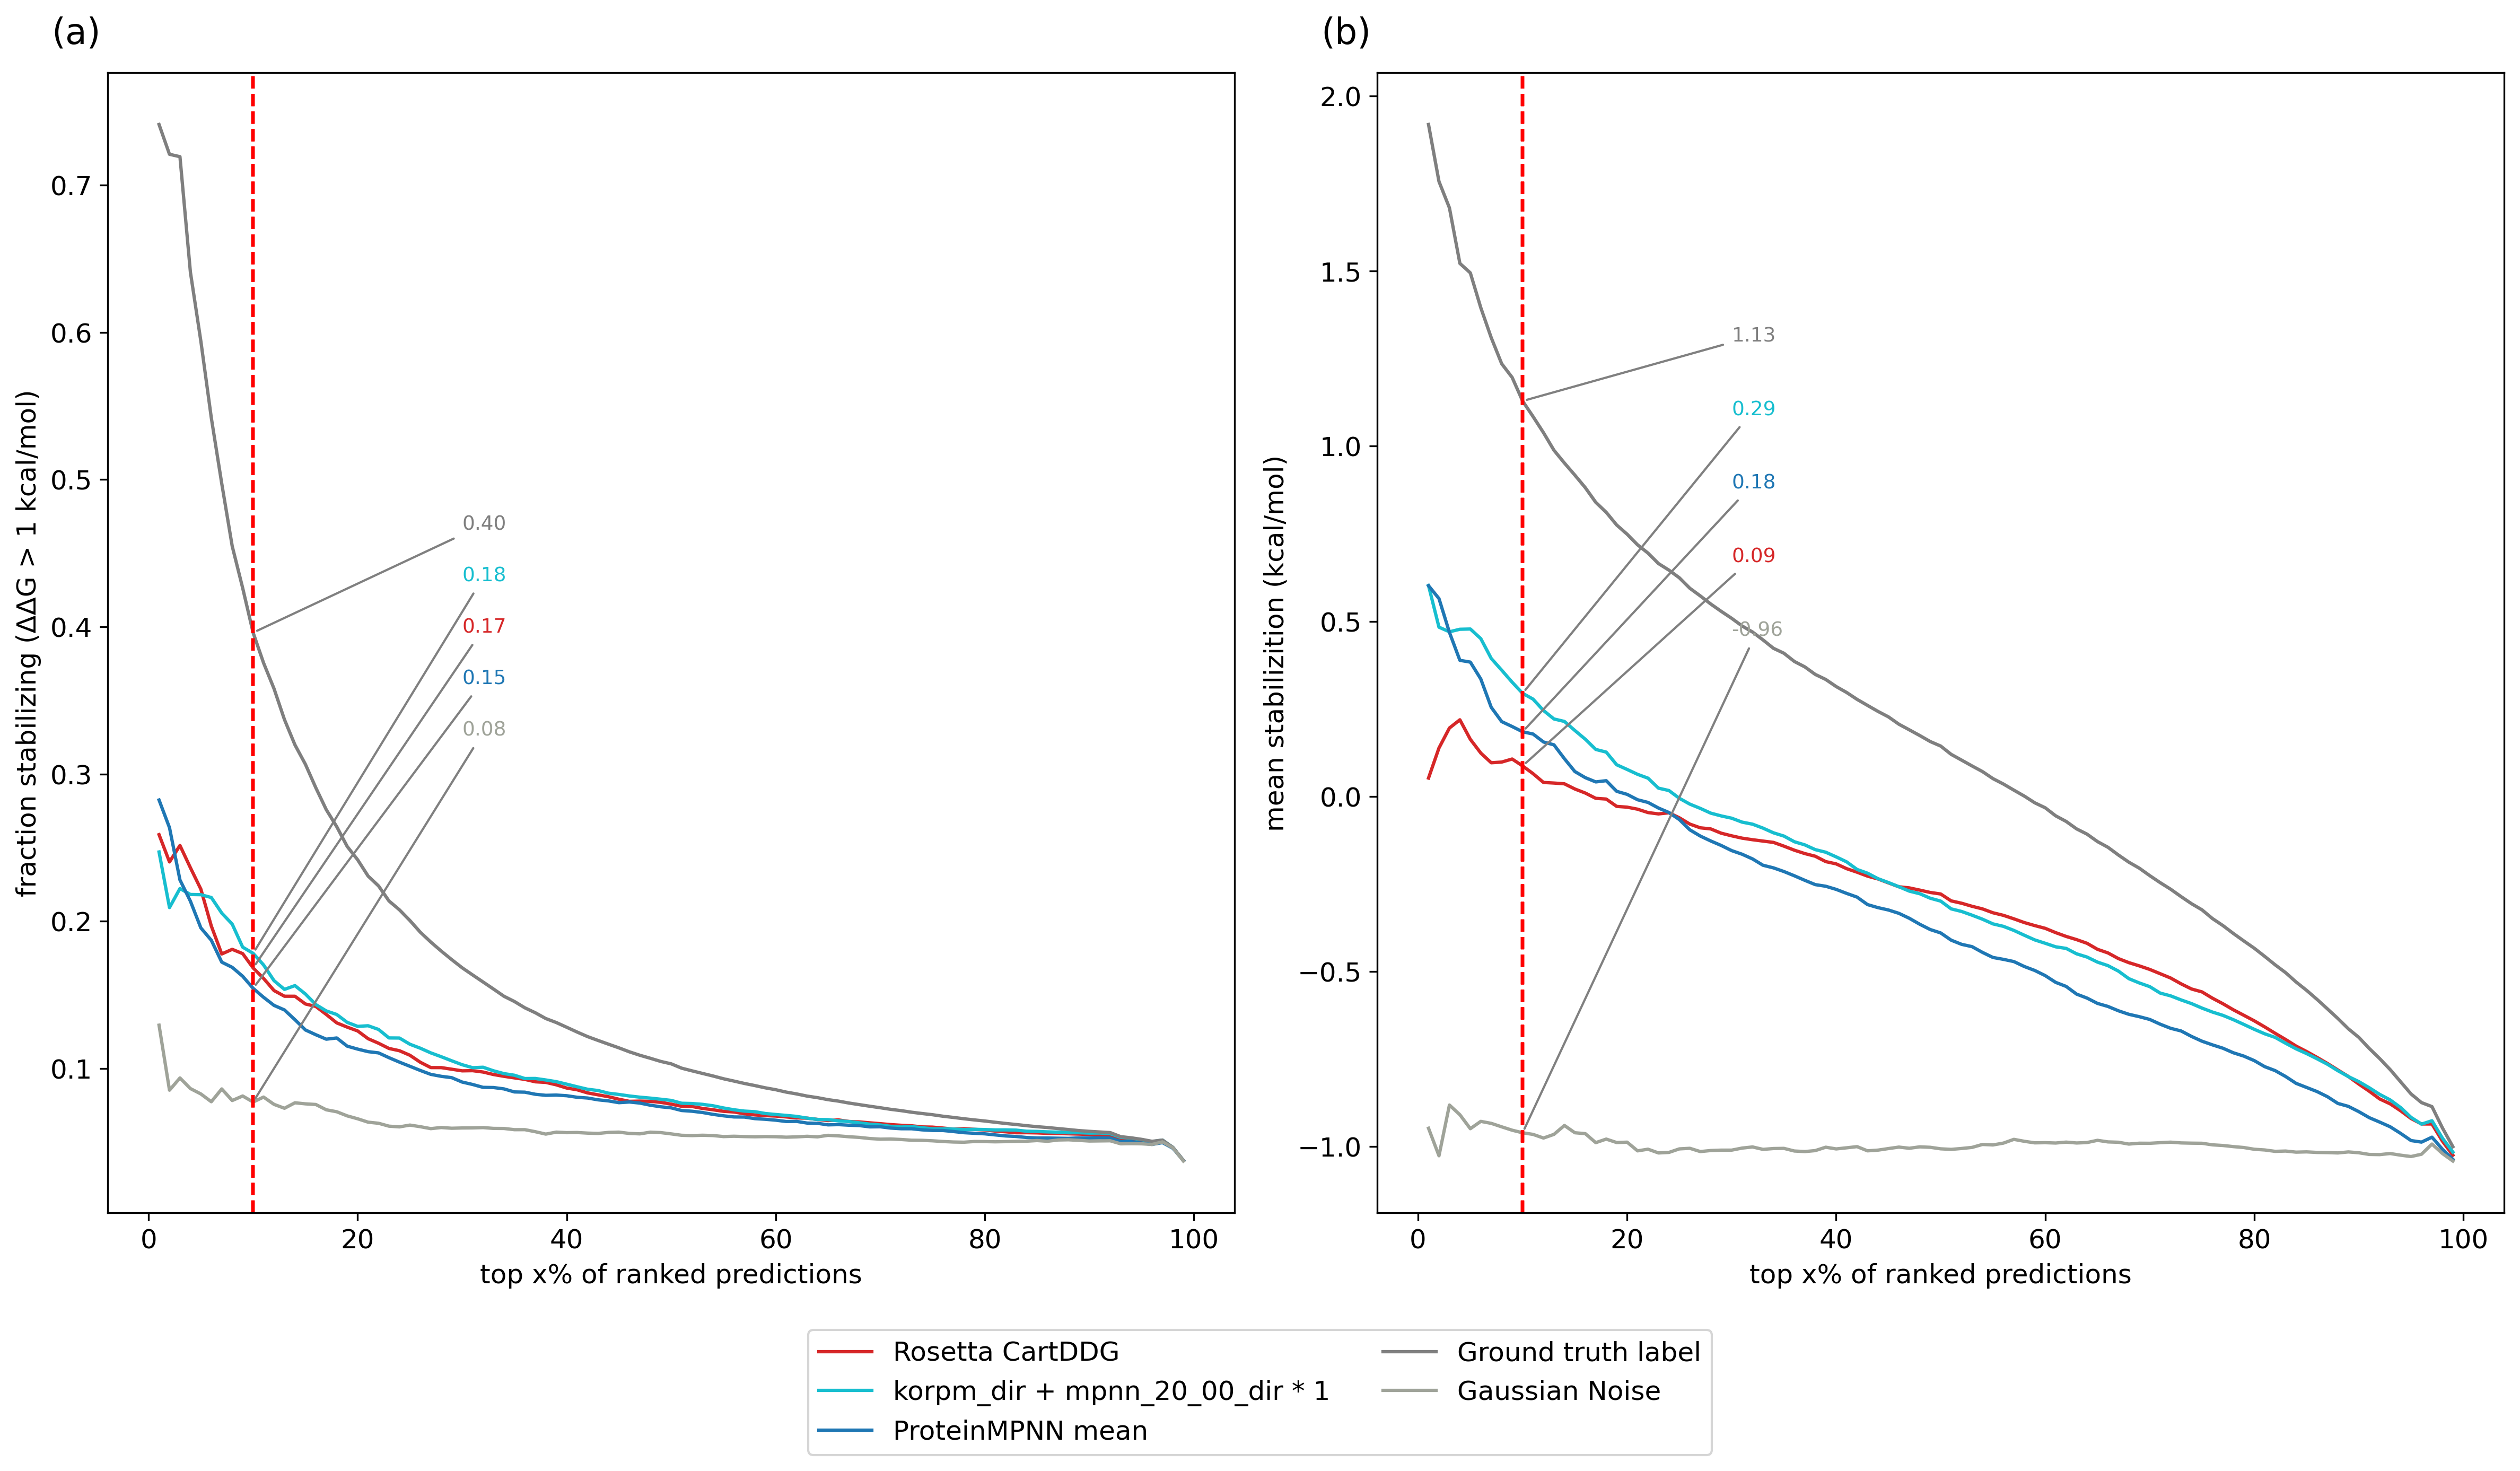

In [ ]:
# extra figure (not in text)
analysis_utils.recovery_curves(d1.reset_index(), ['mpnn_mean_dir', 'cartesian_ddg_dir', 'korpm_dir + mpnn_20_00_dir * 1', 'ddG_dir', 'dTm_dir', 'random_dir'], spacing=0.07, measurements=['ddG'])